In [1]:
from __future__ import print_function

import locale
from warnings import warn
import time

from scipy.optimize import curve_fit
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state, check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA, TruncatedSVD

try:
    import joblib
except ImportError:
    # sklearn.externals.joblib is deprecated in 0.21, will be removed in 0.23
    from sklearn.externals import joblib

import numpy as np
import scipy.sparse
from scipy.sparse import tril as sparse_tril, triu as sparse_triu
import scipy.sparse.csgraph
import numba

import umap.distances as dist

import umap.sparse as sparse

from umap.utils import (
    submatrix,
    ts,
    csr_unique,
    fast_knn_indices,
)
from umap.spectral import spectral_layout
from umap.layouts import (
    optimize_layout_euclidean,
    optimize_layout_generic,
    optimize_layout_inverse,
)

from pynndescent import NNDescent
from pynndescent.distances import named_distances as pynn_named_distances
from pynndescent.sparse import sparse_named_distances as pynn_sparse_named_distances


In [7]:
def myUMAP():
# Author: Leland McInnes <leland.mcinnes@gmail.com>
#
# License: BSD 3 clause
print("hello")
locale.setlocale(locale.LC_NUMERIC, "C")

INT32_MIN = np.iinfo(np.int32).min + 1
INT32_MAX = np.iinfo(np.int32).max - 1

SMOOTH_K_TOLERANCE = 1e-5
MIN_K_DIST_SCALE = 1e-3
NPY_INFINITY = np.inf

DISCONNECTION_DISTANCES = {
    "correlation": 2,
    "cosine": 2,
    "hellinger": 1,
    "jaccard": 1,
    "dice": 1,
}


def flatten_iter(container):
    for i in container:
        if isinstance(i, (list, tuple)):
            for j in flatten_iter(i):
                yield j
        else:
            yield i


def flattened(container):
    return tuple(flatten_iter(container))


def breadth_first_search(adjmat, start, min_vertices):
    explored = []
    queue = [start]
    levels = {}
    levels[start] = 0
    max_level = np.inf
    visited = [start]

    while queue:
        node = queue.pop(0)
        explored.append(node)
        if max_level == np.inf and len(explored) > min_vertices:
            max_level = max(levels.values())

        if levels[node] + 1 < max_level:
            neighbors = adjmat[node].indices
            for neighbour in neighbors:
                if neighbour not in visited:
                    queue.append(neighbour)
                    visited.append(neighbour)

                    levels[neighbour] = levels[node] + 1

    return np.array(explored)


def raise_disconnected_warning(
    edges_removed,
    vertices_disconnected,
    disconnection_distance,
    total_rows,
    threshold=0.1,
    verbose=False,
):
    """A simple wrapper function to avoid large amounts of code repetition."""
    if verbose & (vertices_disconnected == 0) & (edges_removed > 0):
        print(
            f"Disconnection_distance = {disconnection_distance} has removed {edges_removed} edges.  "
            f"This is not a problem as no vertices were disconnected."
        )
    elif (vertices_disconnected > 0) & (
        vertices_disconnected <= threshold * total_rows
    ):
        warn(
            f"A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.\n"
            f"Disconnection_distance = {disconnection_distance} has removed {edges_removed} edges.\n"
            f"It has only fully disconnected {vertices_disconnected} vertices.\n"
            f"Use umap.utils.disconnected_vertices() to identify them.",
        )
    elif vertices_disconnected > threshold * total_rows:
        warn(
            f"A large number of your vertices were disconnected from the manifold.\n"
            f"Disconnection_distance = {disconnection_distance} has removed {edges_removed} edges.\n"
            f"It has fully disconnected {vertices_disconnected} vertices.\n"
            f"You might consider using find_disconnected_points() to find and remove these points from your data.\n"
            f"Use umap.utils.disconnected_vertices() to identify them.",
        )


@numba.njit(
    locals={
        "psum": numba.types.float32,
        "lo": numba.types.float32,
        "mid": numba.types.float32,
        "hi": numba.types.float32,
    },
    fastmath=True,
)  # benchmarking `parallel=True` shows it to *decrease* performance
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=1.0, bandwidth=1.0):
    """Compute a continuous version of the distance to the kth nearest
    neighbor. That is, this is similar to knn-distance but allows continuous
    k values rather than requiring an integral k. In essence we are simply
    computing the distance such that the cardinality of fuzzy set we generate
    is k.

    Parameters
    ----------
    distances: array of shape (n_samples, n_neighbors)
        Distances to nearest neighbors for each sample. Each row should be a
        sorted list of distances to a given samples nearest neighbors.

    k: float
        The number of nearest neighbors to approximate for.

    n_iter: int (optional, default 64)
        We need to binary search for the correct distance value. This is the
        max number of iterations to use in such a search.

    local_connectivity: int (optional, default 1)
        The local connectivity required -- i.e. the number of nearest
        neighbors that should be assumed to be connected at a local level.
        The higher this value the more connected the manifold becomes
        locally. In practice this should be not more than the local intrinsic
        dimension of the manifold.

    bandwidth: float (optional, default 1)
        The target bandwidth of the kernel, larger values will produce
        larger return values.

    Returns
    -------
    knn_dist: array of shape (n_samples,)
        The distance to kth nearest neighbor, as suitably approximated.

    nn_dist: array of shape (n_samples,)
        The distance to the 1st nearest neighbor for each point.
    """
    target = np.log2(k) * bandwidth
    rho = np.zeros(distances.shape[0], dtype=np.float32)
    result = np.zeros(distances.shape[0], dtype=np.float32)

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = NPY_INFINITY
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > SMOOTH_K_TOLERANCE:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
                else:
                    psum += 1.0

            if np.fabs(psum - target) < SMOOTH_K_TOLERANCE:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == NPY_INFINITY:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0

        result[i] = mid

        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < MIN_K_DIST_SCALE * mean_ith_distances:
                result[i] = MIN_K_DIST_SCALE * mean_ith_distances
        else:
            if result[i] < MIN_K_DIST_SCALE * mean_distances:
                result[i] = MIN_K_DIST_SCALE * mean_distances

    return result, rho


def nearest_neighbors(
    X,
    n_neighbors,
    metric,
    metric_kwds,
    angular,
    random_state,
    low_memory=True,
    use_pynndescent=True,
    n_jobs=-1,
    verbose=False,
):
    """Compute the ``n_neighbors`` nearest points for each data point in ``X``
    under ``metric``. This may be exact, but more likely is approximated via
    nearest neighbor descent.

    Parameters
    ----------
    X: array of shape (n_samples, n_features)
        The input data to compute the k-neighbor graph of.

    n_neighbors: int
        The number of nearest neighbors to compute for each sample in ``X``.

    metric: string or callable
        The metric to use for the computation.

    metric_kwds: dict
        Any arguments to pass to the metric computation function.

    angular: bool
        Whether to use angular rp trees in NN approximation.

    random_state: np.random state
        The random state to use for approximate NN computations.

    low_memory: bool (optional, default True)
        Whether to pursue lower memory NNdescent.

    verbose: bool (optional, default False)
        Whether to print status data during the computation.

    Returns
    -------
    knn_indices: array of shape (n_samples, n_neighbors)
        The indices on the ``n_neighbors`` closest points in the dataset.

    knn_dists: array of shape (n_samples, n_neighbors)
        The distances to the ``n_neighbors`` closest points in the dataset.

    rp_forest: list of trees
        The random projection forest used for searching (if used, None otherwise).
    """
    if verbose:
        print(ts(), "Finding Nearest Neighbors")

    if metric == "precomputed":
        # Note that this does not support sparse distance matrices yet ...
        # Compute indices of n nearest neighbors
        knn_indices = fast_knn_indices(X, n_neighbors)
        # knn_indices = np.argsort(X)[:, :n_neighbors]
        # Compute the nearest neighbor distances
        #   (equivalent to np.sort(X)[:,:n_neighbors])
        knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
        # Prune any nearest neighbours that are infinite distance apart.
        disconnected_index = knn_dists == np.inf
        knn_indices[disconnected_index] = -1

        knn_search_index = None
    else:
        # TODO: Hacked values for now
        n_trees = min(64, 5 + int(round((X.shape[0]) ** 0.5 / 20.0)))
        n_iters = max(5, int(round(np.log2(X.shape[0]))))

        knn_search_index = NNDescent(
            X,
            n_neighbors=n_neighbors,
            metric=metric,
            metric_kwds=metric_kwds,
            random_state=random_state,
            n_trees=n_trees,
            n_iters=n_iters,
            max_candidates=60,
            low_memory=low_memory,
            n_jobs=n_jobs,
            verbose=verbose,
            compressed=False,
        )
        knn_indices, knn_dists = knn_search_index.neighbor_graph

    if verbose:
        print(ts(), "Finished Nearest Neighbor Search")
    return knn_indices, knn_dists, knn_search_index


@numba.njit(
    locals={
        "knn_dists": numba.types.float32[:, ::1],
        "sigmas": numba.types.float32[::1],
        "rhos": numba.types.float32[::1],
        "val": numba.types.float32,
    },
    parallel=True,
    fastmath=True,
)
def compute_membership_strengths(
    knn_indices,
    knn_dists,
    sigmas,
    rhos,
    return_dists=False,
    bipartite=False,
):
    """Construct the membership strength data for the 1-skeleton of each local
    fuzzy simplicial set -- this is formed as a sparse matrix where each row is
    a local fuzzy simplicial set, with a membership strength for the
    1-simplex to each other data point.

    Parameters
    ----------
    knn_indices: array of shape (n_samples, n_neighbors)
        The indices on the ``n_neighbors`` closest points in the dataset.

    knn_dists: array of shape (n_samples, n_neighbors)
        The distances to the ``n_neighbors`` closest points in the dataset.

    sigmas: array of shape(n_samples)
        The normalization factor derived from the metric tensor approximation.

    rhos: array of shape(n_samples)
        The local connectivity adjustment.

    return_dists: bool (optional, default False)
        Whether to return the pairwise distance associated with each edge.

    bipartite: bool (optional, default False)
        Does the nearest neighbour set represent a bipartite graph? That is, are the
        nearest neighbour indices from the same point set as the row indices?

    Returns
    -------
    rows: array of shape (n_samples * n_neighbors)
        Row data for the resulting sparse matrix (coo format)

    cols: array of shape (n_samples * n_neighbors)
        Column data for the resulting sparse matrix (coo format)

    vals: array of shape (n_samples * n_neighbors)
        Entries for the resulting sparse matrix (coo format)

    dists: array of shape (n_samples * n_neighbors)
        Distance associated with each entry in the resulting sparse matrix
    """
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]

    rows = np.zeros(knn_indices.size, dtype=np.int32)
    cols = np.zeros(knn_indices.size, dtype=np.int32)
    vals = np.zeros(knn_indices.size, dtype=np.float32)
    if return_dists:
        dists = np.zeros(knn_indices.size, dtype=np.float32)
    else:
        dists = None

    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            # If applied to an adjacency matrix points shouldn't be similar to themselves.
            # If applied to an incidence matrix (or bipartite) then the row and column indices are different.
            if (bipartite == False) & (knn_indices[i, j] == i):
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0 or sigmas[i] == 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val
            if return_dists:
                dists[i * n_neighbors + j] = knn_dists[i, j]

    return rows, cols, vals, dists


def fuzzy_simplicial_set(
    X,
    n_neighbors,
    random_state,
    metric,
    metric_kwds={},
    knn_indices=None,
    knn_dists=None,
    angular=False,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    apply_set_operations=True,
    verbose=False,
    return_dists=None,
):
    """Given a set of data X, a neighborhood size, and a measure of distance
    compute the fuzzy simplicial set (here represented as a fuzzy graph in
    the form of a sparse matrix) associated to the data. This is done by
    locally approximating geodesic distance at each point, creating a fuzzy
    simplicial set for each such point, and then combining all the local
    fuzzy simplicial sets into a global one via a fuzzy union.

    Parameters
    ----------
    X: array of shape (n_samples, n_features)
        The data to be modelled as a fuzzy simplicial set.

    n_neighbors: int
        The number of neighbors to use to approximate geodesic distance.
        Larger numbers induce more global estimates of the manifold that can
        miss finer detail, while smaller values will focus on fine manifold
        structure to the detriment of the larger picture.

    random_state: numpy RandomState or equivalent
        A state capable being used as a numpy random state.

    metric: string or function (optional, default 'euclidean')
        The metric to use to compute distances in high dimensional space.
        If a string is passed it must match a valid predefined metric. If
        a general metric is required a function that takes two 1d arrays and
        returns a float can be provided. For performance purposes it is
        required that this be a numba jit'd function. Valid string metrics
        include:

        * euclidean (or l2)
        * manhattan (or l1)
        * cityblock
        * braycurtis
        * canberra
        * chebyshev
        * correlation
        * cosine
        * dice
        * hamming
        * jaccard
        * kulsinski
        * ll_dirichlet
        * mahalanobis
        * matching
        * minkowski
        * rogerstanimoto
        * russellrao
        * seuclidean
        * sokalmichener
        * sokalsneath
        * sqeuclidean
        * yule
        * wminkowski

        Metrics that take arguments (such as minkowski, mahalanobis etc.)
        can have arguments passed via the metric_kwds dictionary. At this
        time care must be taken and dictionary elements must be ordered
        appropriately; this will hopefully be fixed in the future.

    metric_kwds: dict (optional, default {})
        Arguments to pass on to the metric, such as the ``p`` value for
        Minkowski distance.

    knn_indices: array of shape (n_samples, n_neighbors) (optional)
        If the k-nearest neighbors of each point has already been calculated
        you can pass them in here to save computation time. This should be
        an array with the indices of the k-nearest neighbors as a row for
        each data point.

    knn_dists: array of shape (n_samples, n_neighbors) (optional)
        If the k-nearest neighbors of each point has already been calculated
        you can pass them in here to save computation time. This should be
        an array with the distances of the k-nearest neighbors as a row for
        each data point.

    angular: bool (optional, default False)
        Whether to use angular/cosine distance for the random projection
        forest for seeding NN-descent to determine approximate nearest
        neighbors.

    set_op_mix_ratio: float (optional, default 1.0)
        Interpolate between (fuzzy) union and intersection as the set operation
        used to combine local fuzzy simplicial sets to obtain a global fuzzy
        simplicial sets. Both fuzzy set operations use the product t-norm.
        The value of this parameter should be between 0.0 and 1.0; a value of
        1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy
        intersection.

    local_connectivity: int (optional, default 1)
        The local connectivity required -- i.e. the number of nearest
        neighbors that should be assumed to be connected at a local level.
        The higher this value the more connected the manifold becomes
        locally. In practice this should be not more than the local intrinsic
        dimension of the manifold.

    verbose: bool (optional, default False)
        Whether to report information on the current progress of the algorithm.

    return_dists: bool or None (optional, default None)
        Whether to return the pairwise distance associated with each edge.

    Returns
    -------
    fuzzy_simplicial_set: coo_matrix
        A fuzzy simplicial set represented as a sparse matrix. The (i,
        j) entry of the matrix represents the membership strength of the
        1-simplex between the ith and jth sample points.
    """
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
            X,
            n_neighbors,
            metric,
            metric_kwds,
            angular,
            random_state,
            verbose=verbose,
        )

    knn_dists = knn_dists.astype(np.float32)

    sigmas, rhos = smooth_knn_dist(
        knn_dists,
        float(n_neighbors),
        local_connectivity=float(local_connectivity),
    )

    rows, cols, vals, dists = compute_membership_strengths(
        knn_indices, knn_dists, sigmas, rhos, return_dists
    )

    result = scipy.sparse.coo_matrix(
        (vals, (rows, cols)), shape=(X.shape[0], X.shape[0])
    )
    result.eliminate_zeros()

    if apply_set_operations:
        transpose = result.transpose()

        prod_matrix = result.multiply(transpose)

        result = (
            set_op_mix_ratio * (result + transpose - prod_matrix)
            + (1.0 - set_op_mix_ratio) * prod_matrix
        )

    result.eliminate_zeros()

    if return_dists is None:
        return result, sigmas, rhos
    else:
        if return_dists:
            dmat = scipy.sparse.coo_matrix(
                (dists, (rows, cols)), shape=(X.shape[0], X.shape[0])
            )

            dists = dmat.maximum(dmat.transpose()).todok()
        else:
            dists = None

        return result, sigmas, rhos, dists


@numba.njit()
def fast_intersection(rows, cols, values, target, unknown_dist=1.0, far_dist=5.0):
    """Under the assumption of categorical distance for the intersecting
    simplicial set perform a fast intersection.

    Parameters
    ----------
    rows: array
        An array of the row of each non-zero in the sparse matrix
        representation.

    cols: array
        An array of the column of each non-zero in the sparse matrix
        representation.

    values: array
        An array of the value of each non-zero in the sparse matrix
        representation.

    target: array of shape (n_samples)
        The categorical labels to use in the intersection.

    unknown_dist: float (optional, default 1.0)
        The distance an unknown label (-1) is assumed to be from any point.

    far_dist float (optional, default 5.0)
        The distance between unmatched labels.

    Returns
    -------
    None
    """
    for nz in range(rows.shape[0]):
        i = rows[nz]
        j = cols[nz]
        if (target[i] == -1) or (target[j] == -1):
            values[nz] *= np.exp(-unknown_dist)
        elif target[i] != target[j]:
            values[nz] *= np.exp(-far_dist)

    return


@numba.jit()
def fast_metric_intersection(
    rows, cols, values, discrete_space, metric, metric_args, scale
):
    """Under the assumption of categorical distance for the intersecting
    simplicial set perform a fast intersection.

    Parameters
    ----------
    rows: array
        An array of the row of each non-zero in the sparse matrix
        representation.

    cols: array
        An array of the column of each non-zero in the sparse matrix
        representation.

    values: array of shape
        An array of the values of each non-zero in the sparse matrix
        representation.

    discrete_space: array of shape (n_samples, n_features)
        The vectors of categorical labels to use in the intersection.

    metric: numba function
        The function used to calculate distance over the target array.

    scale: float
        A scaling to apply to the metric.

    Returns
    -------
    None
    """
    for nz in range(rows.shape[0]):
        i = rows[nz]
        j = cols[nz]
        dist = metric(discrete_space[i], discrete_space[j], *metric_args)
        values[nz] *= np.exp(-(scale * dist))

    return


@numba.njit()
def reprocess_row(probabilities, k=15, n_iters=32):
    target = np.log2(k)

    lo = 0.0
    hi = NPY_INFINITY
    mid = 1.0

    for n in range(n_iters):

        psum = 0.0
        for j in range(probabilities.shape[0]):
            psum += pow(probabilities[j], mid)

        if np.fabs(psum - target) < SMOOTH_K_TOLERANCE:
            break

        if psum < target:
            hi = mid
            mid = (lo + hi) / 2.0
        else:
            lo = mid
            if hi == NPY_INFINITY:
                mid *= 2
            else:
                mid = (lo + hi) / 2.0

    return np.power(probabilities, mid)


@numba.njit()
def reset_local_metrics(simplicial_set_indptr, simplicial_set_data):
    for i in range(simplicial_set_indptr.shape[0] - 1):
        simplicial_set_data[
            simplicial_set_indptr[i] : simplicial_set_indptr[i + 1]
        ] = reprocess_row(
            simplicial_set_data[simplicial_set_indptr[i] : simplicial_set_indptr[i + 1]]
        )
    return


def reset_local_connectivity(simplicial_set, reset_local_metric=False):
    """Reset the local connectivity requirement -- each data sample should
    have complete confidence in at least one 1-simplex in the simplicial set.
    We can enforce this by locally rescaling confidences, and then remerging the
    different local simplicial sets together.

    Parameters
    ----------
    simplicial_set: sparse matrix
        The simplicial set for which to recalculate with respect to local
        connectivity.

    Returns
    -------
    simplicial_set: sparse_matrix
        The recalculated simplicial set, now with the local connectivity
        assumption restored.
    """
    simplicial_set = normalize(simplicial_set, norm="max")
    if reset_local_metric:
        simplicial_set = simplicial_set.tocsr()
        reset_local_metrics(simplicial_set.indptr, simplicial_set.data)
        simplicial_set = simplicial_set.tocoo()
    transpose = simplicial_set.transpose()
    prod_matrix = simplicial_set.multiply(transpose)
    simplicial_set = simplicial_set + transpose - prod_matrix
    simplicial_set.eliminate_zeros()

    return simplicial_set


def discrete_metric_simplicial_set_intersection(
    simplicial_set,
    discrete_space,
    unknown_dist=1.0,
    far_dist=5.0,
    metric=None,
    metric_kws={},
    metric_scale=1.0,
):
    """Combine a fuzzy simplicial set with another fuzzy simplicial set
    generated from discrete metric data using discrete distances. The target
    data is assumed to be categorical label data (a vector of labels),
    and this will update the fuzzy simplicial set to respect that label data.

    TODO: optional category cardinality based weighting of distance

    Parameters
    ----------
    simplicial_set: sparse matrix
        The input fuzzy simplicial set.

    discrete_space: array of shape (n_samples)
        The categorical labels to use in the intersection.

    unknown_dist: float (optional, default 1.0)
        The distance an unknown label (-1) is assumed to be from any point.

    far_dist: float (optional, default 5.0)
        The distance between unmatched labels.

    metric: str (optional, default None)
        If not None, then use this metric to determine the
        distance between values.

    metric_scale: float (optional, default 1.0)
        If using a custom metric scale the distance values by
        this value -- this controls the weighting of the
        intersection. Larger values weight more toward target.

    Returns
    -------
    simplicial_set: sparse matrix
        The resulting intersected fuzzy simplicial set.
    """
    simplicial_set = simplicial_set.tocoo()

    if metric is not None:
        # We presume target is now a 2d array, with each row being a
        # vector of target info
        if metric in dist.named_distances:
            metric_func = dist.named_distances[metric]
        else:
            raise ValueError("Discrete intersection metric is not recognized")

        fast_metric_intersection(
            simplicial_set.row,
            simplicial_set.col,
            simplicial_set.data,
            discrete_space,
            metric_func,
            tuple(metric_kws.values()),
            metric_scale,
        )
    else:
        fast_intersection(
            simplicial_set.row,
            simplicial_set.col,
            simplicial_set.data,
            discrete_space,
            unknown_dist,
            far_dist,
        )

    simplicial_set.eliminate_zeros()

    return reset_local_connectivity(simplicial_set)


def general_simplicial_set_intersection(
    simplicial_set1, simplicial_set2, weight=0.5, right_complement=False
):

    if right_complement:
        result = simplicial_set1.tocoo()
    else:
        result = (simplicial_set1 + simplicial_set2).tocoo()
    left = simplicial_set1.tocsr()
    right = simplicial_set2.tocsr()

    sparse.general_sset_intersection(
        left.indptr,
        left.indices,
        left.data,
        right.indptr,
        right.indices,
        right.data,
        result.row,
        result.col,
        result.data,
        mix_weight=weight,
        right_complement=right_complement,
    )

    return result


def general_simplicial_set_union(simplicial_set1, simplicial_set2):
    result = (simplicial_set1 + simplicial_set2).tocoo()
    left = simplicial_set1.tocsr()
    right = simplicial_set2.tocsr()

    sparse.general_sset_union(
        left.indptr,
        left.indices,
        left.data,
        right.indptr,
        right.indices,
        right.data,
        result.row,
        result.col,
        result.data,
    )

    return result


def make_epochs_per_sample(weights, n_epochs):
    """Given a set of weights and number of epochs generate the number of
    epochs per sample for each weight.

    Parameters
    ----------
    weights: array of shape (n_1_simplices)
        The weights of how much we wish to sample each 1-simplex.

    n_epochs: int
        The total number of epochs we want to train for.

    Returns
    -------
    An array of number of epochs per sample, one for each 1-simplex.
    """
    result = -1.0 * np.ones(weights.shape[0], dtype=np.float64)
    n_samples = n_epochs * (weights / weights.max())
    result[n_samples > 0] = float(n_epochs) / np.float64(n_samples[n_samples > 0])
    return result


# scale coords so that the largest coordinate is max_coords, then add normal-distributed
# noise with standard deviation noise
def noisy_scale_coords(coords, random_state, max_coord=10.0, noise=0.0001):
    expansion = max_coord / np.abs(coords).max()
    coords = (coords * expansion).astype(np.float32)
    return coords + random_state.normal(scale=noise, size=coords.shape).astype(
        np.float32
    )


def simplicial_set_embedding(
    data,
    graph,
    n_components,
    initial_alpha,
    a,
    b,
    gamma,
    negative_sample_rate,
    n_epochs,
    init,
    random_state,
    metric,
    metric_kwds,
    densmap,
    densmap_kwds,
    output_dens,
    output_metric=dist.named_distances_with_gradients["euclidean"],
    output_metric_kwds={},
    euclidean_output=True,
    parallel=False,
    verbose=False,
    tqdm_kwds=None,
):
    """Perform a fuzzy simplicial set embedding, using a specified
    initialisation method and then minimizing the fuzzy set cross entropy
    between the 1-skeletons of the high and low dimensional fuzzy simplicial
    sets.

    Parameters
    ----------
    data: array of shape (n_samples, n_features)
        The source data to be embedded by UMAP.

    graph: sparse matrix
        The 1-skeleton of the high dimensional fuzzy simplicial set as
        represented by a graph for which we require a sparse matrix for the
        (weighted) adjacency matrix.

    n_components: int
        The dimensionality of the euclidean space into which to embed the data.

    initial_alpha: float
        Initial learning rate for the SGD.

    a: float
        Parameter of differentiable approximation of right adjoint functor

    b: float
        Parameter of differentiable approximation of right adjoint functor

    gamma: float
        Weight to apply to negative samples.

    negative_sample_rate: int (optional, default 5)
        The number of negative samples to select per positive sample
        in the optimization process. Increasing this value will result
        in greater repulsive force being applied, greater optimization
        cost, but slightly more accuracy.

    n_epochs: int (optional, default 0), or list of int
        The number of training epochs to be used in optimizing the
        low dimensional embedding. Larger values result in more accurate
        embeddings. If 0 is specified a value will be selected based on
        the size of the input dataset (200 for large datasets, 500 for small).
        If a list of int is specified, then the intermediate embeddings at the
        different epochs specified in that list are returned in
        ``aux_data["embedding_list"]``.

    init: string
        How to initialize the low dimensional embedding. Options are:

            * 'spectral': use a spectral embedding of the fuzzy 1-skeleton
            * 'random': assign initial embedding positions at random.
            * 'pca': use the first n_components from PCA applied to the input data.
            * A numpy array of initial embedding positions.

    random_state: numpy RandomState or equivalent
        A state capable being used as a numpy random state.

    metric: string or callable
        The metric used to measure distance in high dimensional space; used if
        multiple connected components need to be layed out.

    metric_kwds: dict
        Key word arguments to be passed to the metric function; used if
        multiple connected components need to be layed out.

    densmap: bool
        Whether to use the density-augmented objective function to optimize
        the embedding according to the densMAP algorithm.

    densmap_kwds: dict
        Key word arguments to be used by the densMAP optimization.

    output_dens: bool
        Whether to output local radii in the original data and the embedding.

    output_metric: function
        Function returning the distance between two points in embedding space and
        the gradient of the distance wrt the first argument.

    output_metric_kwds: dict
        Key word arguments to be passed to the output_metric function.

    euclidean_output: bool
        Whether to use the faster code specialised for euclidean output metrics

    parallel: bool (optional, default False)
        Whether to run the computation using numba parallel.
        Running in parallel is non-deterministic, and is not used
        if a random seed has been set, to ensure reproducibility.

    verbose: bool (optional, default False)
        Whether to report information on the current progress of the algorithm.

    tqdm_kwds: dict
        Key word arguments to be used by the tqdm progress bar.

    Returns
    -------
    embedding: array of shape (n_samples, n_components)
        The optimized of ``graph`` into an ``n_components`` dimensional
        euclidean space.

    aux_data: dict
        Auxiliary output returned with the embedding. When densMAP extension
        is turned on, this dictionary includes local radii in the original
        data (``rad_orig``) and in the embedding (``rad_emb``).
    """
    graph = graph.tocoo()
    graph.sum_duplicates()
    n_vertices = graph.shape[1]

    # For smaller datasets we can use more epochs
    if graph.shape[0] <= 10000:
        default_epochs = 500
    else:
        default_epochs = 200

    # Use more epochs for densMAP
    if densmap:
        default_epochs += 200

    if n_epochs is None:
        n_epochs = default_epochs

    # If n_epoch is a list, get the maximum epoch to reach
    n_epochs_max = max(n_epochs) if isinstance(n_epochs, list) else n_epochs

    if n_epochs_max > 10:
        graph.data[graph.data < (graph.data.max() / float(n_epochs_max))] = 0.0
    else:
        graph.data[graph.data < (graph.data.max() / float(default_epochs))] = 0.0

    graph.eliminate_zeros()

    if isinstance(init, str) and init == "random":
        embedding = random_state.uniform(
            low=-10.0, high=10.0, size=(graph.shape[0], n_components)
        ).astype(np.float32)
    elif isinstance(init, str) and init == "pca":
        if scipy.sparse.issparse(data):
            pca = TruncatedSVD(n_components=n_components, random_state=random_state)
        else:
            pca = PCA(n_components=n_components, random_state=random_state)
        embedding = pca.fit_transform(data).astype(np.float32)
        embedding = noisy_scale_coords(
            embedding, random_state, max_coord=10, noise=0.0001
        )
    elif isinstance(init, str) and init == "spectral":
        embedding = spectral_layout(
            data,
            graph,
            n_components,
            random_state,
            metric=metric,
            metric_kwds=metric_kwds,
        )
        # We add a little noise to avoid local minima for optimization to come
        embedding = noisy_scale_coords(
            embedding, random_state, max_coord=10, noise=0.0001
        )
    else:
        init_data = np.array(init)
        if len(init_data.shape) == 2:
            if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                tree = KDTree(init_data)
                dist, ind = tree.query(init_data, k=2)
                nndist = np.mean(dist[:, 1])
                embedding = init_data + random_state.normal(
                    scale=0.001 * nndist, size=init_data.shape
                ).astype(np.float32)
            else:
                embedding = init_data

    epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs_max)

    head = graph.row
    tail = graph.col
    weight = graph.data

    rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

    aux_data = {}

    if densmap or output_dens:
        if verbose:
            print(ts() + " Computing original densities")

        dists = densmap_kwds["graph_dists"]

        mu_sum = np.zeros(n_vertices, dtype=np.float32)
        ro = np.zeros(n_vertices, dtype=np.float32)
        for i in range(len(head)):
            j = head[i]
            k = tail[i]

            D = dists[j, k] * dists[j, k]  # match sq-Euclidean used for embedding
            mu = graph.data[i]

            ro[j] += mu * D
            ro[k] += mu * D
            mu_sum[j] += mu
            mu_sum[k] += mu

        epsilon = 1e-8
        ro = np.log(epsilon + (ro / mu_sum))

        if densmap:
            R = (ro - np.mean(ro)) / np.std(ro)
            densmap_kwds["mu"] = graph.data
            densmap_kwds["mu_sum"] = mu_sum
            densmap_kwds["R"] = R

        if output_dens:
            aux_data["rad_orig"] = ro

    embedding = (
        10.0
        * (embedding - np.min(embedding, 0))
        / (np.max(embedding, 0) - np.min(embedding, 0))
    ).astype(np.float32, order="C")

    if euclidean_output:
        embedding = optimize_layout_euclidean(
            embedding,
            embedding,
            head,
            tail,
            n_epochs,
            n_vertices,
            epochs_per_sample,
            a,
            b,
            rng_state,
            gamma,
            initial_alpha,
            negative_sample_rate,
            parallel=parallel,
            verbose=verbose,
            densmap=densmap,
            densmap_kwds=densmap_kwds,
            tqdm_kwds=tqdm_kwds,
            move_other=True,
        )
    else:
        embedding = optimize_layout_generic(
            embedding,
            embedding,
            head,
            tail,
            n_epochs,
            n_vertices,
            epochs_per_sample,
            a,
            b,
            rng_state,
            gamma,
            initial_alpha,
            negative_sample_rate,
            output_metric,
            tuple(output_metric_kwds.values()),
            verbose=verbose,
            tqdm_kwds=tqdm_kwds,
            move_other=True,
        )

    if isinstance(embedding, list):
        aux_data["embedding_list"] = embedding
        embedding = embedding[-1].copy()

    if output_dens:
        if verbose:
            print(ts() + " Computing embedding densities")

        # Compute graph in embedding
        (knn_indices, knn_dists, rp_forest,) = nearest_neighbors(
            embedding,
            densmap_kwds["n_neighbors"],
            "euclidean",
            {},
            False,
            random_state,
            verbose=verbose,
        )

        emb_graph, emb_sigmas, emb_rhos, emb_dists = fuzzy_simplicial_set(
            embedding,
            densmap_kwds["n_neighbors"],
            random_state,
            "euclidean",
            {},
            knn_indices,
            knn_dists,
            verbose=verbose,
            return_dists=True,
        )

        emb_graph = emb_graph.tocoo()
        emb_graph.sum_duplicates()
        emb_graph.eliminate_zeros()

        n_vertices = emb_graph.shape[1]

        mu_sum = np.zeros(n_vertices, dtype=np.float32)
        re = np.zeros(n_vertices, dtype=np.float32)

        head = emb_graph.row
        tail = emb_graph.col
        for i in range(len(head)):
            j = head[i]
            k = tail[i]

            D = emb_dists[j, k]
            mu = emb_graph.data[i]

            re[j] += mu * D
            re[k] += mu * D
            mu_sum[j] += mu
            mu_sum[k] += mu

        epsilon = 1e-8
        re = np.log(epsilon + (re / mu_sum))

        aux_data["rad_emb"] = re

    return embedding, aux_data


@numba.njit()
def init_transform(indices, weights, embedding):
    """Given indices and weights and an original embeddings
    initialize the positions of new points relative to the
    indices and weights (of their neighbors in the source data).

    Parameters
    ----------
    indices: array of shape (n_new_samples, n_neighbors)
        The indices of the neighbors of each new sample

    weights: array of shape (n_new_samples, n_neighbors)
        The membership strengths of associated 1-simplices
        for each of the new samples.

    embedding: array of shape (n_samples, dim)
        The original embedding of the source data.

    Returns
    -------
    new_embedding: array of shape (n_new_samples, dim)
        An initial embedding of the new sample points.
    """
    result = np.zeros((indices.shape[0], embedding.shape[1]), dtype=np.float32)

    for i in range(indices.shape[0]):
        for j in range(indices.shape[1]):
            for d in range(embedding.shape[1]):
                result[i, d] += weights[i, j] * embedding[indices[i, j], d]

    return result


def init_graph_transform(graph, embedding):
    """Given a bipartite graph representing the 1-simplices and strengths between the
    new points and the original data set along with an embedding of the original points
    initialize the positions of new points relative to the strengths (of their neighbors in the source data).

    If a point is in our original data set it embeds at the original points coordinates.
    If a point has no neighbours in our original dataset it embeds as the np.nan vector.
    Otherwise a point is the weighted average of it's neighbours embedding locations.

    Parameters
    ----------
    graph: csr_matrix (n_new_samples, n_samples)
        A matrix indicating the 1-simplices and their associated strengths.  These strengths should
        be values between zero and one and not normalized.  One indicating that the new point was identical
        to one of our original points.

    embedding: array of shape (n_samples, dim)
        The original embedding of the source data.

    Returns
    -------
    new_embedding: array of shape (n_new_samples, dim)
        An initial embedding of the new sample points.
    """
    result = np.zeros((graph.shape[0], embedding.shape[1]), dtype=np.float32)

    for row_index in range(graph.shape[0]):
        num_neighbours = len(graph[row_index].indices)
        if num_neighbours == 0:
            result[row_index] = np.nan
            continue
        row_sum = np.sum(graph[row_index])
        for col_index in graph[row_index].indices:
            if graph[row_index, col_index] == 1:
                result[row_index, :] = embedding[col_index, :]
                break
            for d in range(embedding.shape[1]):
                result[row_index, d] += (
                    graph[row_index, col_index] / row_sum * embedding[col_index, d]
                )

    return result


@numba.njit()
def init_update(current_init, n_original_samples, indices):
    for i in range(n_original_samples, indices.shape[0]):
        n = 0
        for j in range(indices.shape[1]):
            for d in range(current_init.shape[1]):
                if indices[i, j] < n_original_samples:
                    n += 1
                    current_init[i, d] += current_init[indices[i, j], d]
        for d in range(current_init.shape[1]):
            current_init[i, d] /= n

    return


def find_ab_params(spread, min_dist):
    """Fit a, b params for the differentiable curve used in lower
    dimensional fuzzy simplicial complex construction. We want the
    smooth curve (from a pre-defined family with simple gradient) that
    best matches an offset exponential decay.
    """

    def curve(x, a, b):
        return 1.0 / (1.0 + a * x ** (2 * b))

    xv = np.linspace(0, spread * 3, 300)
    yv = np.zeros(xv.shape)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
    params, covar = curve_fit(curve, xv, yv)
    return params[0], params[1]


class UMAP(BaseEstimator):
    """Uniform Manifold Approximation and Projection

    Finds a low dimensional embedding of the data that approximates
    an underlying manifold.

    Parameters
    ----------
    n_neighbors: float (optional, default 15)
        The size of local neighborhood (in terms of number of neighboring
        sample points) used for manifold approximation. Larger values
        result in more global views of the manifold, while smaller
        values result in more local data being preserved. In general
        values should be in the range 2 to 100.

    n_components: int (optional, default 2)
        The dimension of the space to embed into. This defaults to 2 to
        provide easy visualization, but can reasonably be set to any
        integer value in the range 2 to 100.

    metric: string or function (optional, default 'euclidean')
        The metric to use to compute distances in high dimensional space.
        If a string is passed it must match a valid predefined metric. If
        a general metric is required a function that takes two 1d arrays and
        returns a float can be provided. For performance purposes it is
        required that this be a numba jit'd function. Valid string metrics
        include:

        * euclidean
        * manhattan
        * chebyshev
        * minkowski
        * canberra
        * braycurtis
        * mahalanobis
        * wminkowski
        * seuclidean
        * cosine
        * correlation
        * haversine
        * hamming
        * jaccard
        * dice
        * russelrao
        * kulsinski
        * ll_dirichlet
        * hellinger
        * rogerstanimoto
        * sokalmichener
        * sokalsneath
        * yule

        Metrics that take arguments (such as minkowski, mahalanobis etc.)
        can have arguments passed via the metric_kwds dictionary. At this
        time care must be taken and dictionary elements must be ordered
        appropriately; this will hopefully be fixed in the future.

    n_epochs: int (optional, default None)
        The number of training epochs to be used in optimizing the
        low dimensional embedding. Larger values result in more accurate
        embeddings. If None is specified a value will be selected based on
        the size of the input dataset (200 for large datasets, 500 for small).

    learning_rate: float (optional, default 1.0)
        The initial learning rate for the embedding optimization.

    init: string (optional, default 'spectral')
        How to initialize the low dimensional embedding. Options are:

            * 'spectral': use a spectral embedding of the fuzzy 1-skeleton
            * 'random': assign initial embedding positions at random.
            * 'pca': use the first n_components from PCA applied to the input data.
            * A numpy array of initial embedding positions.

    min_dist: float (optional, default 0.1)
        The effective minimum distance between embedded points. Smaller values
        will result in a more clustered/clumped embedding where nearby points
        on the manifold are drawn closer together, while larger values will
        result on a more even dispersal of points. The value should be set
        relative to the ``spread`` value, which determines the scale at which
        embedded points will be spread out.

    spread: float (optional, default 1.0)
        The effective scale of embedded points. In combination with ``min_dist``
        this determines how clustered/clumped the embedded points are.

    low_memory: bool (optional, default True)
        For some datasets the nearest neighbor computation can consume a lot of
        memory. If you find that UMAP is failing due to memory constraints
        consider setting this option to True. This approach is more
        computationally expensive, but avoids excessive memory use.

    set_op_mix_ratio: float (optional, default 1.0)
        Interpolate between (fuzzy) union and intersection as the set operation
        used to combine local fuzzy simplicial sets to obtain a global fuzzy
        simplicial sets. Both fuzzy set operations use the product t-norm.
        The value of this parameter should be between 0.0 and 1.0; a value of
        1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy
        intersection.

    local_connectivity: int (optional, default 1)
        The local connectivity required -- i.e. the number of nearest
        neighbors that should be assumed to be connected at a local level.
        The higher this value the more connected the manifold becomes
        locally. In practice this should be not more than the local intrinsic
        dimension of the manifold.

    repulsion_strength: float (optional, default 1.0)
        Weighting applied to negative samples in low dimensional embedding
        optimization. Values higher than one will result in greater weight
        being given to negative samples.

    negative_sample_rate: int (optional, default 5)
        The number of negative samples to select per positive sample
        in the optimization process. Increasing this value will result
        in greater repulsive force being applied, greater optimization
        cost, but slightly more accuracy.

    transform_queue_size: float (optional, default 4.0)
        For transform operations (embedding new points using a trained model
        this will control how aggressively to search for nearest neighbors.
        Larger values will result in slower performance but more accurate
        nearest neighbor evaluation.

    a: float (optional, default None)
        More specific parameters controlling the embedding. If None these
        values are set automatically as determined by ``min_dist`` and
        ``spread``.
    b: float (optional, default None)
        More specific parameters controlling the embedding. If None these
        values are set automatically as determined by ``min_dist`` and
        ``spread``.

    random_state: int, RandomState instance or None, optional (default: None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    metric_kwds: dict (optional, default None)
        Arguments to pass on to the metric, such as the ``p`` value for
        Minkowski distance. If None then no arguments are passed on.

    angular_rp_forest: bool (optional, default False)
        Whether to use an angular random projection forest to initialise
        the approximate nearest neighbor search. This can be faster, but is
        mostly on useful for metric that use an angular style distance such
        as cosine, correlation etc. In the case of those metrics angular forests
        will be chosen automatically.

    target_n_neighbors: int (optional, default -1)
        The number of nearest neighbors to use to construct the target simplcial
        set. If set to -1 use the ``n_neighbors`` value.

    target_metric: string or callable (optional, default 'categorical')
        The metric used to measure distance for a target array is using supervised
        dimension reduction. By default this is 'categorical' which will measure
        distance in terms of whether categories match or are different. Furthermore,
        if semi-supervised is required target values of -1 will be trated as
        unlabelled under the 'categorical' metric. If the target array takes
        continuous values (e.g. for a regression problem) then metric of 'l1'
        or 'l2' is probably more appropriate.

    target_metric_kwds: dict (optional, default None)
        Keyword argument to pass to the target metric when performing
        supervised dimension reduction. If None then no arguments are passed on.

    target_weight: float (optional, default 0.5)
        weighting factor between data topology and target topology. A value of
        0.0 weights predominantly on data, a value of 1.0 places a strong emphasis on
        target. The default of 0.5 balances the weighting equally between data and
        target.

    transform_seed: int (optional, default 42)
        Random seed used for the stochastic aspects of the transform operation.
        This ensures consistency in transform operations.

    verbose: bool (optional, default False)
        Controls verbosity of logging.

    tqdm_kwds: dict (optional, defaul None)
        Key word arguments to be used by the tqdm progress bar.

    unique: bool (optional, default False)
        Controls if the rows of your data should be uniqued before being
        embedded.  If you have more duplicates than you have n_neighbour
        you can have the identical data points lying in different regions of
        your space.  It also violates the definition of a metric.
        For to map from internal structures back to your data use the variable
        _unique_inverse_.

    densmap: bool (optional, default False)
        Specifies whether the density-augmented objective of densMAP
        should be used for optimization. Turning on this option generates
        an embedding where the local densities are encouraged to be correlated
        with those in the original space. Parameters below with the prefix 'dens'
        further control the behavior of this extension.

    dens_lambda: float (optional, default 2.0)
        Controls the regularization weight of the density correlation term
        in densMAP. Higher values prioritize density preservation over the
        UMAP objective, and vice versa for values closer to zero. Setting this
        parameter to zero is equivalent to running the original UMAP algorithm.

    dens_frac: float (optional, default 0.3)
        Controls the fraction of epochs (between 0 and 1) where the
        density-augmented objective is used in densMAP. The first
        (1 - dens_frac) fraction of epochs optimize the original UMAP objective
        before introducing the density correlation term.

    dens_var_shift: float (optional, default 0.1)
        A small constant added to the variance of local radii in the
        embedding when calculating the density correlation objective to
        prevent numerical instability from dividing by a small number

    output_dens: float (optional, default False)
        Determines whether the local radii of the final embedding (an inverse
        measure of local density) are computed and returned in addition to
        the embedding. If set to True, local radii of the original data
        are also included in the output for comparison; the output is a tuple
        (embedding, original local radii, embedding local radii). This option
        can also be used when densmap=False to calculate the densities for
        UMAP embeddings.

    disconnection_distance: float (optional, default np.inf or maximal value for bounded distances)
        Disconnect any vertices of distance greater than or equal to disconnection_distance when approximating the
        manifold via our k-nn graph. This is particularly useful in the case that you have a bounded metric.  The
        UMAP assumption that we have a connected manifold can be problematic when you have points that are maximally
        different from all the rest of your data.  The connected manifold assumption will make such points have perfect
        similarity to a random set of other points.  Too many such points will artificially connect your space.

    precomputed_knn: tuple (optional, default (None,None,None))
        If the k-nearest neighbors of each point has already been calculated you
        can pass them in here to save computation time. The number of nearest
        neighbors in the precomputed_knn must be greater or equal to the
        n_neighbors parameter. This should be a tuple containing the output
        of the nearest_neighbors() function or attributes from a previously fit
        UMAP object; (knn_indices, knn_dists, knn_search_index). If you wish to use
        k-nearest neighbors data calculated by another package then provide a tuple of
        the form (knn_indices, knn_dists). The contents of the tuple should be two numpy
        arrays of shape (N, n_neighbors) where N is the number of items in the
        input data. The first array should be the integer indices of the nearest
        neighbors, and the second array should be the corresponding distances. The
        nearest neighbor of each item should be itself, e.g. the nearest neighbor of
        item 0 should be 0, the nearest neighbor of item 1 is 1 and so on. Please note
        that you will *not* be able to transform new data in this case.
    """

    def __init__(
        self,
        n_neighbors=15,
        n_components=2,
        metric="euclidean",
        metric_kwds=None,
        output_metric="euclidean",
        output_metric_kwds=None,
        n_epochs=None,
        learning_rate=1.0,
        init="spectral",
        min_dist=0.1,
        spread=1.0,
        low_memory=True,
        n_jobs=-1,
        set_op_mix_ratio=1.0,
        local_connectivity=1.0,
        repulsion_strength=1.0,
        negative_sample_rate=5,
        transform_queue_size=4.0,
        a=None,
        b=None,
        random_state=None,
        angular_rp_forest=False,
        target_n_neighbors=-1,
        target_metric="categorical",
        target_metric_kwds=None,
        target_weight=0.5,
        transform_seed=42,
        transform_mode="embedding",
        force_approximation_algorithm=False,
        verbose=False,
        tqdm_kwds=None,
        unique=False,
        densmap=False,
        dens_lambda=2.0,
        dens_frac=0.3,
        dens_var_shift=0.1,
        output_dens=False,
        disconnection_distance=None,
        precomputed_knn=(None, None, None),
    ):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.output_metric = output_metric
        self.target_metric = target_metric
        self.metric_kwds = metric_kwds
        self.output_metric_kwds = output_metric_kwds
        self.n_epochs = n_epochs
        self.init = init
        self.n_components = n_components
        self.repulsion_strength = repulsion_strength
        self.learning_rate = learning_rate

        self.spread = spread
        self.min_dist = min_dist
        self.low_memory = low_memory
        self.set_op_mix_ratio = set_op_mix_ratio
        self.local_connectivity = local_connectivity
        self.negative_sample_rate = negative_sample_rate
        self.random_state = random_state
        self.angular_rp_forest = angular_rp_forest
        self.transform_queue_size = transform_queue_size
        self.target_n_neighbors = target_n_neighbors
        self.target_metric = target_metric
        self.target_metric_kwds = target_metric_kwds
        self.target_weight = target_weight
        self.transform_seed = transform_seed
        self.transform_mode = transform_mode
        self.force_approximation_algorithm = force_approximation_algorithm
        self.verbose = verbose
        self.tqdm_kwds = tqdm_kwds
        self.unique = unique

        self.densmap = densmap
        self.dens_lambda = dens_lambda
        self.dens_frac = dens_frac
        self.dens_var_shift = dens_var_shift
        self.output_dens = output_dens
        self.disconnection_distance = disconnection_distance
        self.precomputed_knn = precomputed_knn

        self.n_jobs = n_jobs

        self.a = a
        self.b = b

    def _validate_parameters(self):
        if self.set_op_mix_ratio < 0.0 or self.set_op_mix_ratio > 1.0:
            raise ValueError("set_op_mix_ratio must be between 0.0 and 1.0")
        if self.repulsion_strength < 0.0:
            raise ValueError("repulsion_strength cannot be negative")
        if self.min_dist > self.spread:
            raise ValueError("min_dist must be less than or equal to spread")
        if self.min_dist < 0.0:
            raise ValueError("min_dist cannot be negative")
        if not isinstance(self.init, str) and not isinstance(self.init, np.ndarray):
            raise ValueError("init must be a string or ndarray")
        if isinstance(self.init, str) and self.init not in (
            "pca",
            "spectral",
            "random",
        ):
            raise ValueError('string init values must be "pca", "spectral" or "random"')
        if (
            isinstance(self.init, np.ndarray)
            and self.init.shape[1] != self.n_components
        ):
            raise ValueError("init ndarray must match n_components value")
        if not isinstance(self.metric, str) and not callable(self.metric):
            raise ValueError("metric must be string or callable")
        if self.negative_sample_rate < 0:
            raise ValueError("negative sample rate must be positive")
        if self._initial_alpha < 0.0:
            raise ValueError("learning_rate must be positive")
        if self.n_neighbors < 2:
            raise ValueError("n_neighbors must be greater than 1")
        if self.target_n_neighbors < 2 and self.target_n_neighbors != -1:
            raise ValueError("target_n_neighbors must be greater than 1")
        if not isinstance(self.n_components, int):
            if isinstance(self.n_components, str):
                raise ValueError("n_components must be an int")
            if self.n_components % 1 != 0:
                raise ValueError("n_components must be a whole number")
            try:
                # this will convert other types of int (eg. numpy int64)
                # to Python int
                self.n_components = int(self.n_components)
            except ValueError:
                raise ValueError("n_components must be an int")
        if self.n_components < 1:
            raise ValueError("n_components must be greater than 0")
        self.n_epochs_list = None
        if isinstance(self.n_epochs, list) or isinstance(self.n_epochs, tuple) or \
                isinstance(self.n_epochs, np.ndarray):
            if not issubclass(np.array(self.n_epochs).dtype.type, np.integer) or \
                    not np.all(np.array(self.n_epochs) >= 0):
                raise ValueError("n_epochs must be a nonnegative integer "
                                 "or a list of nonnegative integers")
            self.n_epochs_list = list(self.n_epochs)
        elif self.n_epochs is not None and (
                self.n_epochs < 0 or not isinstance(self.n_epochs, int)
        ):
            raise ValueError("n_epochs must be a nonnegative integer "
                             "or a list of nonnegative integers")
        if self.metric_kwds is None:
            self._metric_kwds = {}
        else:
            self._metric_kwds = self.metric_kwds
        if self.output_metric_kwds is None:
            self._output_metric_kwds = {}
        else:
            self._output_metric_kwds = self.output_metric_kwds
        if self.target_metric_kwds is None:
            self._target_metric_kwds = {}
        else:
            self._target_metric_kwds = self.target_metric_kwds
        # check sparsity of data upfront to set proper _input_distance_func &
        # save repeated checks later on
        if scipy.sparse.isspmatrix_csr(self._raw_data):
            self._sparse_data = True
        else:
            self._sparse_data = False
        # set input distance metric & inverse_transform distance metric
        if callable(self.metric):
            in_returns_grad = self._check_custom_metric(
                self.metric, self._metric_kwds, self._raw_data
            )
            if in_returns_grad:
                _m = self.metric

                @numba.njit(fastmath=True)
                def _dist_only(x, y, *kwds):
                    return _m(x, y, *kwds)[0]

                self._input_distance_func = _dist_only
                self._inverse_distance_func = self.metric
            else:
                self._input_distance_func = self.metric
                self._inverse_distance_func = None
                warn(
                    "custom distance metric does not return gradient; inverse_transform will be unavailable. "
                    "To enable using inverse_transform method, define a distance function that returns a tuple "
                    "of (distance [float], gradient [np.array])"
                )
        elif self.metric == "precomputed":
            if self.unique:
                raise ValueError("unique is poorly defined on a precomputed metric")
            warn("using precomputed metric; inverse_transform will be unavailable")
            self._input_distance_func = self.metric
            self._inverse_distance_func = None
        elif self.metric == "hellinger" and self._raw_data.min() < 0:
            raise ValueError("Metric 'hellinger' does not support negative values")
        elif self.metric in dist.named_distances:
            if self._sparse_data:
                if self.metric in sparse.sparse_named_distances:
                    self._input_distance_func = sparse.sparse_named_distances[
                        self.metric
                    ]
                else:
                    raise ValueError(
                        "Metric {} is not supported for sparse data".format(self.metric)
                    )
            else:
                self._input_distance_func = dist.named_distances[self.metric]
            try:
                self._inverse_distance_func = dist.named_distances_with_gradients[
                    self.metric
                ]
            except KeyError:
                warn(
                    "gradient function is not yet implemented for {} distance metric; "
                    "inverse_transform will be unavailable".format(self.metric)
                )
                self._inverse_distance_func = None
        elif self.metric in pynn_named_distances:
            if self._sparse_data:
                if self.metric in pynn_sparse_named_distances:
                    self._input_distance_func = pynn_sparse_named_distances[self.metric]
                else:
                    raise ValueError(
                        "Metric {} is not supported for sparse data".format(self.metric)
                    )
            else:
                self._input_distance_func = pynn_named_distances[self.metric]

            warn(
                "gradient function is not yet implemented for {} distance metric; "
                "inverse_transform will be unavailable".format(self.metric)
            )
            self._inverse_distance_func = None
        else:
            raise ValueError("metric is neither callable nor a recognised string")
        # set output distance metric
        if callable(self.output_metric):
            out_returns_grad = self._check_custom_metric(
                self.output_metric, self._output_metric_kwds
            )
            if out_returns_grad:
                self._output_distance_func = self.output_metric
            else:
                raise ValueError(
                    "custom output_metric must return a tuple of (distance [float], gradient [np.array])"
                )
        elif self.output_metric == "precomputed":
            raise ValueError("output_metric cannnot be 'precomputed'")
        elif self.output_metric in dist.named_distances_with_gradients:
            self._output_distance_func = dist.named_distances_with_gradients[
                self.output_metric
            ]
        elif self.output_metric in dist.named_distances:
            raise ValueError(
                "gradient function is not yet implemented for {}.".format(
                    self.output_metric
                )
            )
        else:
            raise ValueError(
                "output_metric is neither callable nor a recognised string"
            )
        # set angularity for NN search based on metric
        if self.metric in (
            "cosine",
            "correlation",
            "dice",
            "jaccard",
            "ll_dirichlet",
            "hellinger",
        ):
            self.angular_rp_forest = True

        if self.n_jobs < -1 or self.n_jobs == 0:
            raise ValueError("n_jobs must be a postive integer, or -1 (for all cores)")

        if self.dens_lambda < 0.0:
            raise ValueError("dens_lambda cannot be negative")
        if self.dens_frac < 0.0 or self.dens_frac > 1.0:
            raise ValueError("dens_frac must be between 0.0 and 1.0")
        if self.dens_var_shift < 0.0:
            raise ValueError("dens_var_shift cannot be negative")

        self._densmap_kwds = {
            "lambda": self.dens_lambda if self.densmap else 0.0,
            "frac": self.dens_frac if self.densmap else 0.0,
            "var_shift": self.dens_var_shift,
            "n_neighbors": self.n_neighbors,
        }

        if self.densmap:
            if self.output_metric not in ("euclidean", "l2"):
                raise ValueError(
                    "Non-Euclidean output metric not supported for densMAP."
                )

        # This will be used to prune all edges of greater than a fixed value from our knn graph.
        # We have preset defaults described in DISCONNECTION_DISTANCES for our bounded measures.
        # Otherwise a user can pass in their own value.
        if self.disconnection_distance is None:
            self._disconnection_distance = DISCONNECTION_DISTANCES.get(
                self.metric, np.inf
            )
        elif isinstance(self.disconnection_distance, int) or isinstance(
            self.disconnection_distance, float
        ):
            self._disconnection_distance = self.disconnection_distance
        else:
            raise ValueError("disconnection_distance must either be None or a numeric.")

        if self.tqdm_kwds is None:
            self.tqdm_kwds = {}
        else:
            if isinstance(self.tqdm_kwds, dict) is False:
                raise ValueError(
                    "tqdm_kwds must be a dictionary. Please provide valid tqdm "
                    "parameters as key value pairs. Valid tqdm parameters can be "
                    "found here: https://github.com/tqdm/tqdm#parameters"
                )
        if "desc" not in self.tqdm_kwds:
            self.tqdm_kwds["desc"] = "Epochs completed"
        if "bar_format" not in self.tqdm_kwds:
            bar_f = "{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]"
            self.tqdm_kwds["bar_format"] = bar_f

        if hasattr(self, "knn_dists") and self.knn_dists is not None:
            if self.unique:
                raise ValueError(
                    "unique is not currently available for " "precomputed_knn."
                )
            if not isinstance(self.knn_indices, np.ndarray):
                raise ValueError("precomputed_knn[0] must be ndarray object.")
            if not isinstance(self.knn_dists, np.ndarray):
                raise ValueError("precomputed_knn[1] must be ndarray object.")
            if self.knn_dists.shape != self.knn_indices.shape:
                raise ValueError(
                    "precomputed_knn[0] and precomputed_knn[1]"
                    " must be numpy arrays of the same size."
                )
            # #848: warn but proceed if no search index is present
            if not isinstance(self.knn_search_index, NNDescent):
                warn(
                    "precomputed_knn[2] (knn_search_index) "
                    "is not an NNDescent object: transforming new data with transform "
                    "will be unavailable."
                )
            if self.knn_dists.shape[1] < self.n_neighbors:
                warn(
                    "precomputed_knn has a lower number of neighbors than "
                    "n_neighbors parameter. precomputed_knn will be ignored"
                    " and the k-nn will be computed normally."
                )
                self.knn_indices = None
                self.knn_dists = None
                self.knn_search_index = None
            elif self.knn_dists.shape[0] != self._raw_data.shape[0]:
                warn(
                    "precomputed_knn has a different number of samples than the"
                    " data you are fitting. precomputed_knn will be ignored and"
                    "the k-nn will be computed normally."
                )
                self.knn_indices = None
                self.knn_dists = None
                self.knn_search_index = None
            elif (
                self.knn_dists.shape[0] < 4096
                and not self.force_approximation_algorithm
            ):
                # force_approximation_algorithm is irrelevant for pre-computed knn
                # always set it to True which keeps downstream code paths working
                self.force_approximation_algorithm = True
            elif self.knn_dists.shape[1] > self.n_neighbors:
                # if k for precomputed_knn larger than n_neighbors we simply prune it
                self.knn_indices = self.knn_indices[:, : self.n_neighbors]
                self.knn_dists = self.knn_dists[:, : self.n_neighbors]

    def _check_custom_metric(self, metric, kwds, data=None):
        # quickly check to determine whether user-defined
        # self.metric/self.output_metric returns both distance and gradient
        if data is not None:
            # if checking the high-dimensional distance metric, test directly on
            # input data so we don't risk violating any assumptions potentially
            # hard-coded in the metric (e.g., bounded; non-negative)
            x, y = data[np.random.randint(0, data.shape[0], 2)]
        else:
            # if checking the manifold distance metric, simulate some data on a
            # reasonable interval with output dimensionality
            x, y = np.random.uniform(low=-10, high=10, size=(2, self.n_components))

        if scipy.sparse.issparse(data):
            metric_out = metric(x.indices, x.data, y.indices, y.data, **kwds)
        else:
            metric_out = metric(x, y, **kwds)
        # True if metric returns iterable of length 2, False otherwise
        return hasattr(metric_out, "__iter__") and len(metric_out) == 2

    def _populate_combined_params(self, *models):
        self.n_neighbors = flattened([m.n_neighbors for m in models])
        self.metric = flattened([m.metric for m in models])
        self.metric_kwds = flattened([m.metric_kwds for m in models])
        self.output_metric = flattened([m.output_metric for m in models])

        self.n_epochs = flattened(
            [m.n_epochs if m.n_epochs is not None else -1 for m in models]
        )
        if all([x == -1 for x in self.n_epochs]):
            self.n_epochs = None

        self.init = flattened([m.init for m in models])
        self.n_components = flattened([m.n_components for m in models])
        self.repulsion_strength = flattened([m.repulsion_strength for m in models])
        self.learning_rate = flattened([m.learning_rate for m in models])

        self.spread = flattened([m.spread for m in models])
        self.min_dist = flattened([m.min_dist for m in models])
        self.low_memory = flattened([m.low_memory for m in models])
        self.set_op_mix_ratio = flattened([m.set_op_mix_ratio for m in models])
        self.local_connectivity = flattened([m.local_connectivity for m in models])
        self.negative_sample_rate = flattened([m.negative_sample_rate for m in models])
        self.random_state = flattened([m.random_state for m in models])
        self.angular_rp_forest = flattened([m.angular_rp_forest for m in models])
        self.transform_queue_size = flattened([m.transform_queue_size for m in models])
        self.target_n_neighbors = flattened([m.target_n_neighbors for m in models])
        self.target_metric = flattened([m.target_metric for m in models])
        self.target_metric_kwds = flattened([m.target_metric_kwds for m in models])
        self.target_weight = flattened([m.target_weight for m in models])
        self.transform_seed = flattened([m.transform_seed for m in models])
        self.force_approximation_algorithm = flattened(
            [m.force_approximation_algorithm for m in models]
        )
        self.verbose = flattened([m.verbose for m in models])
        self.unique = flattened([m.unique for m in models])

        self.densmap = flattened([m.densmap for m in models])
        self.dens_lambda = flattened([m.dens_lambda for m in models])
        self.dens_frac = flattened([m.dens_frac for m in models])
        self.dens_var_shift = flattened([m.dens_var_shift for m in models])
        self.output_dens = flattened([m.output_dens for m in models])

        self.a = flattened([m.a for m in models])
        self.b = flattened([m.b for m in models])

        self._a = flattened([m._a for m in models])
        self._b = flattened([m._b for m in models])

    def __mul__(self, other):

        check_is_fitted(
            self, attributes=["graph_"], msg="Only fitted UMAP models can be combined"
        )
        check_is_fitted(
            other, attributes=["graph_"], msg="Only fitted UMAP models can be combined"
        )

        if self.graph_.shape[0] != other.graph_.shape[0]:
            raise ValueError("Only models with the equivalent samples can be combined")

        result = UMAP()
        result._populate_combined_params(self, other)

        result.graph_ = general_simplicial_set_intersection(
            self.graph_, other.graph_, 0.5
        )
        result.graph_ = reset_local_connectivity(result.graph_, True)

        if scipy.sparse.csgraph.connected_components(result.graph_)[0] > 1:
            warn(
                "Combined graph is not connected but multi-component layout is unsupported. "
                "Falling back to random initialization."
            )
            init = "random"
        else:
            init = "spectral"

        result.densmap = np.any(result.densmap)
        result.output_dens = np.any(result.output_dens)

        result._densmap_kwds = {
            "lambda": np.max(result.dens_lambda),
            "frac": np.max(result.dens_frac),
            "var_shift": np.max(result.dens_var_shift),
            "n_neighbors": np.max(result.n_neighbors),
        }

        if result.n_epochs is None:
            n_epochs = None
        else:
            n_epochs = np.max(result.n_epochs)

        result.embedding_, aux_data = simplicial_set_embedding(
            None,
            result.graph_,
            np.min(result.n_components),
            np.min(result.learning_rate),
            np.mean(result._a),
            np.mean(result._b),
            np.mean(result.repulsion_strength),
            np.mean(result.negative_sample_rate),
            n_epochs,
            init,
            check_random_state(42),
            "euclidean",
            {},
            result.densmap,
            result._densmap_kwds,
            result.output_dens,
            parallel=False,
            verbose=bool(np.max(result.verbose)),
            tqdm_kwds=self.tqdm_kwds,
        )

        if result.output_dens:
            result.rad_orig_ = aux_data["rad_orig"]
            result.rad_emb_ = aux_data["rad_emb"]

        return result

    def __add__(self, other):

        check_is_fitted(
            self, attributes=["graph_"], msg="Only fitted UMAP models can be combined"
        )
        check_is_fitted(
            other, attributes=["graph_"], msg="Only fitted UMAP models can be combined"
        )

        if self.graph_.shape[0] != other.graph_.shape[0]:
            raise ValueError("Only models with the equivalent samples can be combined")

        result = UMAP()
        result._populate_combined_params(self, other)

        result.graph_ = general_simplicial_set_union(self.graph_, other.graph_)
        result.graph_ = reset_local_connectivity(result.graph_, True)

        if scipy.sparse.csgraph.connected_components(result.graph_)[0] > 1:
            warn(
                "Combined graph is not connected but mult-component layout is unsupported. "
                "Falling back to random initialization."
            )
            init = "random"
        else:
            init = "spectral"

        result.densmap = np.any(result.densmap)
        result.output_dens = np.any(result.output_dens)

        result._densmap_kwds = {
            "lambda": np.max(result.dens_lambda),
            "frac": np.max(result.dens_frac),
            "var_shift": np.max(result.dens_var_shift),
            "n_neighbors": np.max(result.n_neighbors),
        }

        if result.n_epochs is None:
            n_epochs = None
        else:
            n_epochs = np.max(result.n_epochs)

        result.embedding_, aux_data = simplicial_set_embedding(
            None,
            result.graph_,
            np.min(result.n_components),
            np.min(result.learning_rate),
            np.mean(result._a),
            np.mean(result._b),
            np.mean(result.repulsion_strength),
            np.mean(result.negative_sample_rate),
            n_epochs,
            init,
            check_random_state(42),
            "euclidean",
            {},
            result.densmap,
            result._densmap_kwds,
            result.output_dens,
            parallel=False,
            verbose=bool(np.max(result.verbose)),
            tqdm_kwds=self.tqdm_kwds,
        )

        if result.output_dens:
            result.rad_orig_ = aux_data["rad_orig"]
            result.rad_emb_ = aux_data["rad_emb"]

        return result

    def __sub__(self, other):

        check_is_fitted(
            self, attributes=["graph_"], msg="Only fitted UMAP models can be combined"
        )
        check_is_fitted(
            other, attributes=["graph_"], msg="Only fitted UMAP models can be combined"
        )

        if self.graph_.shape[0] != other.graph_.shape[0]:
            raise ValueError("Only models with the equivalent samples can be combined")

        result = UMAP()
        result._populate_combined_params(self, other)

        result.graph_ = general_simplicial_set_intersection(
            self.graph_, other.graph_, weight=0.5, right_complement=True
        )
        result.graph_ = reset_local_connectivity(result.graph_, False)

        if scipy.sparse.csgraph.connected_components(result.graph_)[0] > 1:
            warn(
                "Combined graph is not connected but mult-component layout is unsupported. "
                "Falling back to random initialization."
            )
            init = "random"
        else:
            init = "spectral"

        result.densmap = np.any(result.densmap)
        result.output_dens = np.any(result.output_dens)

        result._densmap_kwds = {
            "lambda": np.max(result.dens_lambda),
            "frac": np.max(result.dens_frac),
            "var_shift": np.max(result.dens_var_shift),
            "n_neighbors": np.max(result.n_neighbors),
        }

        if result.n_epochs is None:
            n_epochs = None
        else:
            n_epochs = np.max(result.n_epochs)

        result.embedding_, aux_data = simplicial_set_embedding(
            None,
            result.graph_,
            np.min(result.n_components),
            np.min(result.learning_rate),
            np.mean(result._a),
            np.mean(result._b),
            np.mean(result.repulsion_strength),
            np.mean(result.negative_sample_rate),
            n_epochs,
            init,
            check_random_state(42),
            "euclidean",
            {},
            result.densmap,
            result._densmap_kwds,
            result.output_dens,
            parallel=False,
            verbose=bool(np.max(result.verbose)),
            tqdm_kwds=self.tqdm_kwds,
        )

        if result.output_dens:
            result.rad_orig_ = aux_data["rad_orig"]
            result.rad_emb_ = aux_data["rad_emb"]

        return result

    def fit(self, X, y=None):
        """Fit X into an embedded space.

        Optionally use y for supervised dimension reduction.

        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            If the metric is 'precomputed' X must be a square distance
            matrix. Otherwise it contains a sample per row. If the method
            is 'exact', X may be a sparse matrix of type 'csr', 'csc'
            or 'coo'.

        y : array, shape (n_samples)
            A target array for supervised dimension reduction. How this is
            handled is determined by parameters UMAP was instantiated with.
            The relevant attributes are ``target_metric`` and
            ``target_metric_kwds``.
        """

        X = check_array(X, dtype=np.float32, accept_sparse="csr", order="C")
        self._raw_data = X

        # Handle all the optional arguments, setting default
        if self.a is None or self.b is None:
            self._a, self._b = find_ab_params(self.spread, self.min_dist)
        else:
            self._a = self.a
            self._b = self.b

        if isinstance(self.init, np.ndarray):
            init = check_array(self.init, dtype=np.float32, accept_sparse=False)
        else:
            init = self.init

        self._initial_alpha = self.learning_rate

        self.knn_indices = self.precomputed_knn[0]
        self.knn_dists = self.precomputed_knn[1]
        # #848: allow precomputed knn to not have a search index
        if len(self.precomputed_knn) == 2:
            self.knn_search_index = None
        else:
            self.knn_search_index = self.precomputed_knn[2]

        self._validate_parameters()

        if self.verbose:
            print(str(self))

        self._original_n_threads = numba.get_num_threads()
        if self.n_jobs > 0 and self.n_jobs is not None:
            numba.set_num_threads(self.n_jobs)

        # Check if we should unique the data
        # We've already ensured that we aren't in the precomputed case
        if self.unique:
            # check if the matrix is dense
            if self._sparse_data:
                # Call a sparse unique function
                index, inverse, counts = csr_unique(X)
            else:
                index, inverse, counts = np.unique(
                    X,
                    return_index=True,
                    return_inverse=True,
                    return_counts=True,
                    axis=0,
                )[1:4]
            if self.verbose:
                print(
                    "Unique=True -> Number of data points reduced from ",
                    X.shape[0],
                    " to ",
                    X[index].shape[0],
                )
                most_common = np.argmax(counts)
                print(
                    "Most common duplicate is",
                    index[most_common],
                    " with a count of ",
                    counts[most_common],
                )
            # We'll expose an inverse map when unique=True for users to map from our internal structures to their data
            self._unique_inverse_ = inverse
        # If we aren't asking for unique use the full index.
        # This will save special cases later.
        else:
            index = list(range(X.shape[0]))
            inverse = list(range(X.shape[0]))

        # Error check n_neighbors based on data size
        if X[index].shape[0] <= self.n_neighbors:
            if X[index].shape[0] == 1:
                self.embedding_ = np.zeros(
                    (1, self.n_components)
                )  # needed to sklearn comparability
                return self

            warn(
                "n_neighbors is larger than the dataset size; truncating to "
                "X.shape[0] - 1"
            )
            self._n_neighbors = X[index].shape[0] - 1
            if self.densmap:
                self._densmap_kwds["n_neighbors"] = self._n_neighbors
        else:
            self._n_neighbors = self.n_neighbors

        # Note: unless it causes issues for setting 'index', could move this to
        # initial sparsity check above
        if self._sparse_data and not X.has_sorted_indices:
            X.sort_indices()

        random_state = check_random_state(self.random_state)

        if self.verbose:
            print(ts(), "Construct fuzzy simplicial set")

        if self.metric == "precomputed" and self._sparse_data:
            # For sparse precomputed distance matrices, we just argsort the rows to find
            # nearest neighbors. To make this easier, we expect matrices that are
            # symmetrical (so we can find neighbors by looking at rows in isolation,
            # rather than also having to consider that sample's column too).
            # print("Computing KNNs for sparse precomputed distances...")
            if sparse_tril(X).getnnz() != sparse_triu(X).getnnz():
                raise ValueError(
                    "Sparse precomputed distance matrices should be symmetrical!"
                )
            if not np.all(X.diagonal() == 0):
                raise ValueError("Non-zero distances from samples to themselves!")
            if self.knn_dists is None:
                self._knn_indices = np.zeros(
                    (X.shape[0], self.n_neighbors), dtype=np.int
                )
                self._knn_dists = np.zeros(self._knn_indices.shape, dtype=np.float)
                for row_id in range(X.shape[0]):
                    # Find KNNs row-by-row
                    row_data = X[row_id].data
                    row_indices = X[row_id].indices
                    if len(row_data) < self._n_neighbors:
                        raise ValueError(
                            "Some rows contain fewer than n_neighbors distances!"
                        )
                    row_nn_data_indices = np.argsort(row_data)[: self._n_neighbors]
                    self._knn_indices[row_id] = row_indices[row_nn_data_indices]
                    self._knn_dists[row_id] = row_data[row_nn_data_indices]
            else:
                self._knn_indices = self.knn_indices
                self._knn_dists = self.knn_dists
            # Disconnect any vertices farther apart than _disconnection_distance
            disconnected_index = self._knn_dists >= self._disconnection_distance
            self._knn_indices[disconnected_index] = -1
            self._knn_dists[disconnected_index] = np.inf
            edges_removed = disconnected_index.sum()

            (
                self.graph_,
                self._sigmas,
                self._rhos,
                self.graph_dists_,
            ) = fuzzy_simplicial_set(
                X[index],
                self.n_neighbors,
                random_state,
                "precomputed",
                self._metric_kwds,
                self._knn_indices,
                self._knn_dists,
                self.angular_rp_forest,
                self.set_op_mix_ratio,
                self.local_connectivity,
                True,
                self.verbose,
                self.densmap or self.output_dens,
            )
            # Report the number of vertices with degree 0 in our our umap.graph_
            # This ensures that they were properly disconnected.
            vertices_disconnected = np.sum(
                np.array(self.graph_.sum(axis=1)).flatten() == 0
            )
            raise_disconnected_warning(
                edges_removed,
                vertices_disconnected,
                self._disconnection_distance,
                self._raw_data.shape[0],
                verbose=self.verbose,
            )
        # Handle small cases efficiently by computing all distances
        elif X[index].shape[0] < 4096 and not self.force_approximation_algorithm:
            self._small_data = True
            try:
                # sklearn pairwise_distances fails for callable metric on sparse data
                _m = self.metric if self._sparse_data else self._input_distance_func
                dmat = pairwise_distances(X[index], metric=_m, **self._metric_kwds)
            except (ValueError, TypeError) as e:
                # metric is numba.jit'd or not supported by sklearn,
                # fallback to pairwise special

                if self._sparse_data:
                    # Get a fresh metric since we are casting to dense
                    if not callable(self.metric):
                        _m = dist.named_distances[self.metric]
                        dmat = dist.pairwise_special_metric(
                            X[index].toarray(),
                            metric=_m,
                            kwds=self._metric_kwds,
                        )
                    else:
                        dmat = dist.pairwise_special_metric(
                            X[index],
                            metric=self._input_distance_func,
                            kwds=self._metric_kwds,
                        )
                else:
                    dmat = dist.pairwise_special_metric(
                        X[index],
                        metric=self._input_distance_func,
                        kwds=self._metric_kwds,
                    )
            # set any values greater than disconnection_distance to be np.inf.
            # This will have no effect when _disconnection_distance is not set since it defaults to np.inf.
            edges_removed = np.sum(dmat >= self._disconnection_distance)
            dmat[dmat >= self._disconnection_distance] = np.inf
            (
                self.graph_,
                self._sigmas,
                self._rhos,
                self.graph_dists_,
            ) = fuzzy_simplicial_set(
                dmat,
                self._n_neighbors,
                random_state,
                "precomputed",
                self._metric_kwds,
                None,
                None,
                self.angular_rp_forest,
                self.set_op_mix_ratio,
                self.local_connectivity,
                True,
                self.verbose,
                self.densmap or self.output_dens,
            )
            # Report the number of vertices with degree 0 in our umap.graph_
            # This ensures that they were properly disconnected.
            vertices_disconnected = np.sum(
                np.array(self.graph_.sum(axis=1)).flatten() == 0
            )
            raise_disconnected_warning(
                edges_removed,
                vertices_disconnected,
                self._disconnection_distance,
                self._raw_data.shape[0],
                verbose=self.verbose,
            )
        else:
            # Standard case
            self._small_data = False
            # Standard case
            if self._sparse_data and self.metric in pynn_sparse_named_distances:
                nn_metric = self.metric
            elif not self._sparse_data and self.metric in pynn_named_distances:
                nn_metric = self.metric
            else:
                nn_metric = self._input_distance_func
            if self.knn_dists is None:
                (
                    self._knn_indices,
                    self._knn_dists,
                    self._knn_search_index,
                ) = nearest_neighbors(
                    X[index],
                    self._n_neighbors,
                    nn_metric,
                    self._metric_kwds,
                    self.angular_rp_forest,
                    random_state,
                    self.low_memory,
                    use_pynndescent=True,
                    n_jobs=self.n_jobs,
                    verbose=self.verbose,
                )
            else:
                self._knn_indices = self.knn_indices
                self._knn_dists = self.knn_dists
                self._knn_search_index = self.knn_search_index
            # Disconnect any vertices farther apart than _disconnection_distance
            disconnected_index = self._knn_dists >= self._disconnection_distance
            self._knn_indices[disconnected_index] = -1
            self._knn_dists[disconnected_index] = np.inf
            edges_removed = disconnected_index.sum()

            (
                self.graph_,
                self._sigmas,
                self._rhos,
                self.graph_dists_,
            ) = fuzzy_simplicial_set(
                X[index],
                self.n_neighbors,
                random_state,
                nn_metric,
                self._metric_kwds,
                self._knn_indices,
                self._knn_dists,
                self.angular_rp_forest,
                self.set_op_mix_ratio,
                self.local_connectivity,
                True,
                self.verbose,
                self.densmap or self.output_dens,
            )
            # Report the number of vertices with degree 0 in our umap.graph_
            # This ensures that they were properly disconnected.
            vertices_disconnected = np.sum(
                np.array(self.graph_.sum(axis=1)).flatten() == 0
            )
            raise_disconnected_warning(
                edges_removed,
                vertices_disconnected,
                self._disconnection_distance,
                self._raw_data.shape[0],
                verbose=self.verbose,
            )

        # Currently not checking if any duplicate points have differing labels
        # Might be worth throwing a warning...
        if y is not None:
            len_X = len(X) if not self._sparse_data else X.shape[0]
            if len_X != len(y):
                raise ValueError(
                    "Length of x = {len_x}, length of y = {len_y}, while it must be equal.".format(
                        len_x=len_X, len_y=len(y)
                    )
                )
            if self.target_metric == "string":
                y_ = y[index]
            else:
                y_ = check_array(y, ensure_2d=False)[index]
            if self.target_metric == "categorical":
                if self.target_weight < 1.0:
                    far_dist = 2.5 * (1.0 / (1.0 - self.target_weight))
                else:
                    far_dist = 1.0e12
                self.graph_ = discrete_metric_simplicial_set_intersection(
                    self.graph_, y_, far_dist=far_dist
                )
            elif self.target_metric in dist.DISCRETE_METRICS:
                if self.target_weight < 1.0:
                    scale = 2.5 * (1.0 / (1.0 - self.target_weight))
                else:
                    scale = 1.0e12
                # self.graph_ = discrete_metric_simplicial_set_intersection(
                #     self.graph_,
                #     y_,
                #     metric=self.target_metric,
                #     metric_kws=self.target_metric_kwds,
                #     metric_scale=scale
                # )

                metric_kws = dist.get_discrete_params(y_, self.target_metric)

                self.graph_ = discrete_metric_simplicial_set_intersection(
                    self.graph_,
                    y_,
                    metric=self.target_metric,
                    metric_kws=metric_kws,
                    metric_scale=scale,
                )
            else:
                if len(y_.shape) == 1:
                    y_ = y_.reshape(-1, 1)
                if self.target_n_neighbors == -1:
                    target_n_neighbors = self._n_neighbors
                else:
                    target_n_neighbors = self.target_n_neighbors

                # Handle the small case as precomputed as before
                if y.shape[0] < 4096:
                    try:
                        ydmat = pairwise_distances(
                            y_, metric=self.target_metric, **self._target_metric_kwds
                        )
                    except (TypeError, ValueError):
                        ydmat = dist.pairwise_special_metric(
                            y_,
                            metric=self.target_metric,
                            kwds=self._target_metric_kwds,
                        )

                    (target_graph, target_sigmas, target_rhos,) = fuzzy_simplicial_set(
                        ydmat,
                        target_n_neighbors,
                        random_state,
                        "precomputed",
                        self._target_metric_kwds,
                        None,
                        None,
                        False,
                        1.0,
                        1.0,
                        False,
                    )
                else:
                    # Standard case
                    (target_graph, target_sigmas, target_rhos,) = fuzzy_simplicial_set(
                        y_,
                        target_n_neighbors,
                        random_state,
                        self.target_metric,
                        self._target_metric_kwds,
                        None,
                        None,
                        False,
                        1.0,
                        1.0,
                        False,
                    )
                # product = self.graph_.multiply(target_graph)
                # # self.graph_ = 0.99 * product + 0.01 * (self.graph_ +
                # #                                        target_graph -
                # #                                        product)
                # self.graph_ = product
                self.graph_ = general_simplicial_set_intersection(
                    self.graph_, target_graph, self.target_weight
                )
                self.graph_ = reset_local_connectivity(self.graph_)
            self._supervised = True
        else:
            self._supervised = False

        if self.densmap or self.output_dens:
            self._densmap_kwds["graph_dists"] = self.graph_dists_

        if self.verbose:
            print(ts(), "Construct embedding")

        if self.transform_mode == "embedding":
            epochs = self.n_epochs_list if self.n_epochs_list is not None else self.n_epochs
            self.embedding_, aux_data = self._fit_embed_data(
                self._raw_data[index],
                epochs,
                init,
                random_state,  # JH why raw data?
            )

            if self.n_epochs_list is not None:
                if "embedding_list" not in aux_data:
                    raise KeyError("No list of embedding were found in 'aux_data'. "
                                   "It is likely the layout optimization function "
                                   "doesn't support the list of int for 'n_epochs'.")
                else:
                    self.embedding_list_ = [e[inverse] for e in aux_data["embedding_list"]]

            # Assign any points that are fully disconnected from our manifold(s) to have embedding
            # coordinates of np.nan.  These will be filtered by our plotting functions automatically.
            # They also prevent users from being deceived a distance query to one of these points.
            # Might be worth moving this into simplicial_set_embedding or _fit_embed_data
            disconnected_vertices = np.array(self.graph_.sum(axis=1)).flatten() == 0
            if len(disconnected_vertices) > 0:
                self.embedding_[disconnected_vertices] = np.full(
                    self.n_components, np.nan
                )

            self.embedding_ = self.embedding_[inverse]
            if self.output_dens:
                self.rad_orig_ = aux_data["rad_orig"][inverse]
                self.rad_emb_ = aux_data["rad_emb"][inverse]

        if self.verbose:
            print(ts() + " Finished embedding")

        numba.set_num_threads(self._original_n_threads)
        self._input_hash = joblib.hash(self._raw_data)

        return self

    def _fit_embed_data(self, X, n_epochs, init, random_state):
        """A method wrapper for simplicial_set_embedding that can be
        replaced by subclasses.
        """
        return simplicial_set_embedding(
            X,
            self.graph_,
            self.n_components,
            self._initial_alpha,
            self._a,
            self._b,
            self.repulsion_strength,
            self.negative_sample_rate,
            n_epochs,
            init,
            random_state,
            self._input_distance_func,
            self._metric_kwds,
            self.densmap,
            self._densmap_kwds,
            self.output_dens,
            self._output_distance_func,
            self._output_metric_kwds,
            self.output_metric in ("euclidean", "l2"),
            self.random_state is None,
            self.verbose,
            tqdm_kwds=self.tqdm_kwds,
        )

    def fit_transform(self, X, y=None):
        """Fit X into an embedded space and return that transformed
        output.

        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            If the metric is 'precomputed' X must be a square distance
            matrix. Otherwise it contains a sample per row.

        y : array, shape (n_samples)
            A target array for supervised dimension reduction. How this is
            handled is determined by parameters UMAP was instantiated with.
            The relevant attributes are ``target_metric`` and
            ``target_metric_kwds``.

        Returns
        -------
        X_new : array, shape (n_samples, n_components)
            Embedding of the training data in low-dimensional space.

        or a tuple (X_new, r_orig, r_emb) if ``output_dens`` flag is set,
        which additionally includes:

        r_orig: array, shape (n_samples)
            Local radii of data points in the original data space (log-transformed).

        r_emb: array, shape (n_samples)
            Local radii of data points in the embedding (log-transformed).
        """
        self.fit(X, y)
        if self.transform_mode == "embedding":
            if self.output_dens:
                return self.embedding_, self.rad_orig_, self.rad_emb_
            else:
                return self.embedding_
        elif self.transform_mode == "graph":
            return self.graph_
        else:
            raise ValueError(
                "Unrecognized transform mode {}; should be one of 'embedding' or 'graph'".format(
                    self.transform_mode
                )
            )

    def transform(self, X):
        """Transform X into the existing embedded space and return that
        transformed output.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            New data to be transformed.

        Returns
        -------
        X_new : array, shape (n_samples, n_components)
            Embedding of the new data in low-dimensional space.
        """
        # If we fit just a single instance then error
        if self._raw_data.shape[0] == 1:
            raise ValueError(
                "Transform unavailable when model was fit with only a single data sample."
            )
        # If we just have the original input then short circuit things
        X = check_array(X, dtype=np.float32, accept_sparse="csr", order="C")
        x_hash = joblib.hash(X)
        if x_hash == self._input_hash:
            if self.transform_mode == "embedding":
                return self.embedding_
            elif self.transform_mode == "graph":
                return self.graph_
            else:
                raise ValueError(
                    "Unrecognized transform mode {}; should be one of 'embedding' or 'graph'".format(
                        self.transform_mode
                    )
                )
        if self.densmap:
            raise NotImplementedError(
                "Transforming data into an existing embedding not supported for densMAP."
            )

        # #848: knn_search_index is allowed to be None if not transforming new data,
        # so now we must validate that if it exists it is not None
        if hasattr(self, "_knn_search_index") and self._knn_search_index is None:
            raise NotImplementedError(
                "No search index available: transforming data"
                " into an existing embedding is not supported"
            )

        # X = check_array(X, dtype=np.float32, order="C", accept_sparse="csr")
        random_state = check_random_state(self.transform_seed)
        rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

        if self.metric == "precomputed":
            warn(
                "Transforming new data with precomputed metric. "
                "We are assuming the input data is a matrix of distances from the new points "
                "to the points in the training set. If the input matrix is sparse, it should "
                "contain distances from the new points to their nearest neighbours "
                "or approximate nearest neighbours in the training set."
            )
            assert X.shape[1] == self._raw_data.shape[0]
            if scipy.sparse.issparse(X):
                indices = np.full(
                    (X.shape[0], self._n_neighbors), dtype=np.int32, fill_value=-1
                )
                dists = np.full_like(indices, dtype=np.float32, fill_value=-1)
                for i in range(X.shape[0]):
                    data_indices = np.argsort(X[i].data)
                    if len(data_indices) < self._n_neighbors:
                        raise ValueError(
                            f"Need at least n_neighbors ({self.n_neighbors}) distances for each row!"
                        )
                    indices[i] = X[i].indices[data_indices[: self._n_neighbors]]
                    dists[i] = X[i].data[data_indices[: self._n_neighbors]]
            else:
                indices = np.argsort(X, axis=1)[:, : self._n_neighbors].astype(np.int32)
                dists = np.take_along_axis(X, indices, axis=1)
            assert np.min(indices) >= 0 and np.min(dists) >= 0.0
        elif self._small_data:
            try:
                # sklearn pairwise_distances fails for callable metric on sparse data
                _m = self.metric if self._sparse_data else self._input_distance_func
                dmat = pairwise_distances(
                    X, self._raw_data, metric=_m, **self._metric_kwds
                )
            except (TypeError, ValueError):
                # metric is numba.jit'd or not supported by sklearn,
                # fallback to pairwise special
                if self._sparse_data:
                    # Get a fresh metric since we are casting to dense
                    if not callable(self.metric):
                        _m = dist.named_distances[self.metric]
                        dmat = dist.pairwise_special_metric(
                            X.toarray(),
                            self._raw_data.toarray(),
                            metric=_m,
                            kwds=self._metric_kwds,
                        )
                    else:
                        dmat = dist.pairwise_special_metric(
                            X,
                            self._raw_data,
                            metric=self._input_distance_func,
                            kwds=self._metric_kwds,
                        )
                else:
                    dmat = dist.pairwise_special_metric(
                        X,
                        self._raw_data,
                        metric=self._input_distance_func,
                        kwds=self._metric_kwds,
                    )
            indices = np.argpartition(dmat, self._n_neighbors)[:, : self._n_neighbors]
            dmat_shortened = submatrix(dmat, indices, self._n_neighbors)
            indices_sorted = np.argsort(dmat_shortened)
            indices = submatrix(indices, indices_sorted, self._n_neighbors)
            dists = submatrix(dmat_shortened, indices_sorted, self._n_neighbors)
        else:
            epsilon = 0.24 if self._knn_search_index._angular_trees else 0.12
            indices, dists = self._knn_search_index.query(
                X, self.n_neighbors, epsilon=epsilon
            )

        dists = dists.astype(np.float32, order="C")
        # Remove any nearest neighbours who's distances are greater than our disconnection_distance
        indices[dists >= self._disconnection_distance] = -1
        adjusted_local_connectivity = max(0.0, self.local_connectivity - 1.0)
        sigmas, rhos = smooth_knn_dist(
            dists,
            float(self._n_neighbors),
            local_connectivity=float(adjusted_local_connectivity),
        )

        rows, cols, vals, dists = compute_membership_strengths(
            indices, dists, sigmas, rhos, bipartite=True
        )

        graph = scipy.sparse.coo_matrix(
            (vals, (rows, cols)), shape=(X.shape[0], self._raw_data.shape[0])
        )

        if self.transform_mode == "graph":
            return graph

        # This was a very specially constructed graph with constant degree.
        # That lets us do fancy unpacking by reshaping the csr matrix indices
        # and data. Doing so relies on the constant degree assumption!
        # csr_graph = normalize(graph.tocsr(), norm="l1")
        # inds = csr_graph.indices.reshape(X.shape[0], self._n_neighbors)
        # weights = csr_graph.data.reshape(X.shape[0], self._n_neighbors)
        # embedding = init_transform(inds, weights, self.embedding_)
        # This is less fast code than the above numba.jit'd code.
        # It handles the fact that our nearest neighbour graph can now contain variable numbers of vertices.
        csr_graph = graph.tocsr()
        csr_graph.eliminate_zeros()
        embedding = init_graph_transform(csr_graph, self.embedding_)

        if self.n_epochs is None:
            # For smaller datasets we can use more epochs
            if graph.shape[0] <= 10000:
                n_epochs = 100
            else:
                n_epochs = 30
        else:
            n_epochs = int(self.n_epochs // 3.0)

        graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
        graph.eliminate_zeros()

        epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs)

        head = graph.row
        tail = graph.col
        weight = graph.data

        # optimize_layout = make_optimize_layout(
        #     self._output_distance_func,
        #     tuple(self.output_metric_kwds.values()),
        # )

        if self.output_metric == "euclidean":
            embedding = optimize_layout_euclidean(
                embedding,
                self.embedding_.astype(np.float32, copy=True),  # Fixes #179 & #217,
                head,
                tail,
                n_epochs,
                graph.shape[1],
                epochs_per_sample,
                self._a,
                self._b,
                rng_state,
                self.repulsion_strength,
                self._initial_alpha / 4.0,
                self.negative_sample_rate,
                self.random_state is None,
                verbose=self.verbose,
                tqdm_kwds=self.tqdm_kwds,
            )
        else:
            embedding = optimize_layout_generic(
                embedding,
                self.embedding_.astype(np.float32, copy=True),  # Fixes #179 & #217
                head,
                tail,
                n_epochs,
                graph.shape[1],
                epochs_per_sample,
                self._a,
                self._b,
                rng_state,
                self.repulsion_strength,
                self._initial_alpha / 4.0,
                self.negative_sample_rate,
                self._output_distance_func,
                tuple(self._output_metric_kwds.values()),
                verbose=self.verbose,
                tqdm_kwds=self.tqdm_kwds,
            )

        return embedding

    def inverse_transform(self, X):
        """Transform X in the existing embedded space back into the input
        data space and return that transformed output.

        Parameters
        ----------
        X : array, shape (n_samples, n_components)
            New points to be inverse transformed.

        Returns
        -------
        X_new : array, shape (n_samples, n_features)
            Generated data points new data in data space.
        """

        if self._sparse_data:
            raise ValueError("Inverse transform not available for sparse input.")
        elif self._inverse_distance_func is None:
            raise ValueError("Inverse transform not available for given metric.")
        elif self.densmap:
            raise ValueError("Inverse transform not available for densMAP.")
        elif self.n_components >= 8:
            warn(
                "Inverse transform works best with low dimensional embeddings."
                " Results may be poor, or this approach to inverse transform"
                " may fail altogether! If you need a high dimensional latent"
                " space and inverse transform operations consider using an"
                " autoencoder."
            )
        elif self.transform_mode == "graph":
            raise ValueError(
                "Inverse transform not available for transform_mode = 'graph'"
            )

        X = check_array(X, dtype=np.float32, order="C")
        random_state = check_random_state(self.transform_seed)
        rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

        # build Delaunay complex (Does this not assume a roughly euclidean output metric)?
        deltri = scipy.spatial.Delaunay(
            self.embedding_, incremental=True, qhull_options="QJ"
        )
        neighbors = deltri.simplices[deltri.find_simplex(X)]
        adjmat = scipy.sparse.lil_matrix(
            (self.embedding_.shape[0], self.embedding_.shape[0]), dtype=int
        )
        for i in np.arange(0, deltri.simplices.shape[0]):
            for j in deltri.simplices[i]:
                if j < self.embedding_.shape[0]:
                    idx = deltri.simplices[i][
                        deltri.simplices[i] < self.embedding_.shape[0]
                    ]
                    adjmat[j, idx] = 1
                    adjmat[idx, j] = 1

        adjmat = scipy.sparse.csr_matrix(adjmat)

        min_vertices = min(self._raw_data.shape[-1], self._raw_data.shape[0])

        neighborhood = [
            breadth_first_search(adjmat, v[0], min_vertices=min_vertices)
            for v in neighbors
        ]
        if callable(self.output_metric):
            # need to create another numba.jit-able wrapper for callable
            # output_metrics that return a tuple (already checked that it does
            # during param validation in `fit` method)
            _out_m = self.output_metric

            @numba.njit(fastmath=True)
            def _output_dist_only(x, y, *kwds):
                return _out_m(x, y, *kwds)[0]

            dist_only_func = _output_dist_only
        elif self.output_metric in dist.named_distances.keys():
            dist_only_func = dist.named_distances[self.output_metric]
        else:
            # shouldn't really ever get here because of checks already performed,
            # but works as a failsafe in case attr was altered manually after fitting
            raise ValueError(
                "Unrecognized output metric: {}".format(self.output_metric)
            )

        dist_args = tuple(self._output_metric_kwds.values())
        distances = [
            np.array(
                [
                    dist_only_func(X[i], self.embedding_[nb], *dist_args)
                    for nb in neighborhood[i]
                ]
            )
            for i in range(X.shape[0])
        ]
        idx = np.array([np.argsort(e)[:min_vertices] for e in distances])

        dists_output_space = np.array(
            [distances[i][idx[i]] for i in range(len(distances))]
        )
        indices = np.array([neighborhood[i][idx[i]] for i in range(len(neighborhood))])

        rows, cols, distances = np.array(
            [
                [i, indices[i, j], dists_output_space[i, j]]
                for i in range(indices.shape[0])
                for j in range(min_vertices)
            ]
        ).T

        # calculate membership strength of each edge
        weights = 1 / (1 + self._a * distances ** (2 * self._b))

        # compute 1-skeleton
        # convert 1-skeleton into coo_matrix adjacency matrix
        graph = scipy.sparse.coo_matrix(
            (weights, (rows, cols)), shape=(X.shape[0], self._raw_data.shape[0])
        )

        # That lets us do fancy unpacking by reshaping the csr matrix indices
        # and data. Doing so relies on the constant degree assumption!
        # csr_graph = graph.tocsr()
        csr_graph = normalize(graph.tocsr(), norm="l1")
        inds = csr_graph.indices.reshape(X.shape[0], min_vertices)
        weights = csr_graph.data.reshape(X.shape[0], min_vertices)
        inv_transformed_points = init_transform(inds, weights, self._raw_data)

        if self.n_epochs is None:
            # For smaller datasets we can use more epochs
            if graph.shape[0] <= 10000:
                n_epochs = 100
            else:
                n_epochs = 30
        else:
            n_epochs = int(self.n_epochs // 3.0)

        # graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
        # graph.eliminate_zeros()

        epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs)

        head = graph.row
        tail = graph.col
        weight = graph.data

        inv_transformed_points = optimize_layout_inverse(
            inv_transformed_points,
            self._raw_data,
            head,
            tail,
            weight,
            self._sigmas,
            self._rhos,
            n_epochs,
            graph.shape[1],
            epochs_per_sample,
            self._a,
            self._b,
            rng_state,
            self.repulsion_strength,
            self._initial_alpha / 4.0,
            self.negative_sample_rate,
            self._inverse_distance_func,
            tuple(self._metric_kwds.values()),
            verbose=self.verbose,
            tqdm_kwds=self.tqdm_kwds,
        )

        return inv_transformed_points

    def update(self, X):
        X = check_array(X, dtype=np.float32, accept_sparse="csr", order="C")
        random_state = check_random_state(self.transform_seed)
        rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

        original_size = self._raw_data.shape[0]

        if self.metric == "precomputed":
            raise ValueError("Update does not currently support precomputed metrics")
        if self._supervised:
            raise ValueError("Updating supervised models is not currently " "supported")

        if self._small_data:

            if self._sparse_data:
                self._raw_data = scipy.sparse.vstack([self._raw_data, X])
            else:
                self._raw_data = np.vstack([self._raw_data, X])

            if self._raw_data.shape[0] < 4096:
                # still small data
                try:
                    # sklearn pairwise_distances fails for callable metric on sparse data
                    _m = self.metric if self._sparse_data else self._input_distance_func
                    dmat = pairwise_distances(
                        self._raw_data, metric=_m, **self._metric_kwds
                    )
                except (ValueError, TypeError) as e:
                    # metric is numba.jit'd or not supported by sklearn,
                    # fallback to pairwise special

                    if self._sparse_data:
                        # Get a fresh metric since we are casting to dense
                        if not callable(self.metric):
                            _m = dist.named_distances[self.metric]
                            dmat = dist.pairwise_special_metric(
                                self._raw_data.toarray(),
                                metric=_m,
                                kwds=self._metric_kwds,
                            )
                        else:
                            dmat = dist.pairwise_special_metric(
                                self._raw_data,
                                metric=self._input_distance_func,
                                kwds=self._metric_kwds,
                            )
                    else:
                        dmat = dist.pairwise_special_metric(
                            self._raw_data,
                            metric=self._input_distance_func,
                            kwds=self._metric_kwds,
                        )
                self.graph_, self._sigmas, self._rhos = fuzzy_simplicial_set(
                    dmat,
                    self._n_neighbors,
                    random_state,
                    "precomputed",
                    self._metric_kwds,
                    None,
                    None,
                    self.angular_rp_forest,
                    self.set_op_mix_ratio,
                    self.local_connectivity,
                    True,
                    self.verbose,
                )
                knn_indices = np.argsort(dmat)[:, : self.n_neighbors]
            else:
                # now large data
                self._small_data = False
                if self._sparse_data and self.metric in pynn_sparse_named_distances:
                    nn_metric = self.metric
                elif not self._sparse_data and self.metric in pynn_named_distances:
                    nn_metric = self.metric
                else:
                    nn_metric = self._input_distance_func

                (
                    self._knn_indices,
                    self._knn_dists,
                    self._knn_search_index,
                ) = nearest_neighbors(
                    self._raw_data,
                    self._n_neighbors,
                    nn_metric,
                    self._metric_kwds,
                    self.angular_rp_forest,
                    random_state,
                    self.low_memory,
                    use_pynndescent=True,
                    n_jobs=self.n_jobs,
                    verbose=self.verbose,
                )

                self.graph_, self._sigmas, self._rhos = fuzzy_simplicial_set(
                    self._raw_data,
                    self.n_neighbors,
                    random_state,
                    nn_metric,
                    self._metric_kwds,
                    self._knn_indices,
                    self._knn_dists,
                    self.angular_rp_forest,
                    self.set_op_mix_ratio,
                    self.local_connectivity,
                    True,
                    self.verbose,
                )
                knn_indices = self._knn_indices

            init = np.zeros(
                (self._raw_data.shape[0], self.n_components), dtype=np.float32
            )
            init[:original_size] = self.embedding_

            init_update(init, original_size, knn_indices)
            if self.n_epochs is None:
                n_epochs = 0
            else:
                n_epochs = self.n_epochs

            self.embedding_, aux_data = simplicial_set_embedding(
                self._raw_data,
                self.graph_,
                self.n_components,
                self._initial_alpha,
                self._a,
                self._b,
                self.repulsion_strength,
                self.negative_sample_rate,
                n_epochs,
                init,
                random_state,
                self._input_distance_func,
                self._metric_kwds,
                self.densmap,
                self._densmap_kwds,
                self.output_dens,
                self._output_distance_func,
                self._output_metric_kwds,
                self.output_metric in ("euclidean", "l2"),
                self.random_state is None,
                self.verbose,
                tqdm_kwds=self.tqdm_kwds,
            )

        else:
            self._knn_search_index.prepare()
            self._knn_search_index.update(X)
            self._raw_data = self._knn_search_index._raw_data
            (
                self._knn_indices,
                self._knn_dists,
            ) = self._knn_search_index.neighbor_graph

            if self._sparse_data and self.metric in pynn_sparse_named_distances:
                nn_metric = self.metric
            elif not self._sparse_data and self.metric in pynn_named_distances:
                nn_metric = self.metric
            else:
                nn_metric = self._input_distance_func

            self.graph_, self._sigmas, self._rhos = fuzzy_simplicial_set(
                self._raw_data,
                self.n_neighbors,
                random_state,
                nn_metric,
                self._metric_kwds,
                self._knn_indices,
                self._knn_dists,
                self.angular_rp_forest,
                self.set_op_mix_ratio,
                self.local_connectivity,
                True,
                self.verbose,
            )

            init = np.zeros(
                (self._raw_data.shape[0], self.n_components), dtype=np.float32
            )
            init[:original_size] = self.embedding_
            init_update(init, original_size, self._knn_indices)

            if self.n_epochs is None:
                n_epochs = 0
            else:
                n_epochs = self.n_epochs

            self.embedding_, aux_data = simplicial_set_embedding(
                self._raw_data,
                self.graph_,
                self.n_components,
                self._initial_alpha,
                self._a,
                self._b,
                self.repulsion_strength,
                self.negative_sample_rate,
                n_epochs,
                init,
                random_state,
                self._input_distance_func,
                self._metric_kwds,
                self.densmap,
                self._densmap_kwds,
                self.output_dens,
                self._output_distance_func,
                self._output_metric_kwds,
                self.output_metric in ("euclidean", "l2"),
                self.random_state is None,
                self.verbose,
                tqdm_kwds=self.tqdm_kwds,
            )

        if self.output_dens:
            self.rad_orig_ = aux_data["rad_orig"]
            self.rad_emb_ = aux_data["rad_emb"]

    def get_feature_names_out(self, feature_names_out=None):
        """
        Defines descriptive names for each output of the (fitted) estimator.
        :param feature_names_out: Optional passthrough for feature names.
        By default, feature names will be generated automatically.
        :return: List of descriptive names for each output variable from the fitted estimator.
        """
        if feature_names_out is None:
            feature_names_out = [f"umap_component_{i+1}" for i in range(self.n_components)]
        return feature_names_out

    def __repr__(self):
        from sklearn.utils._pprint import _EstimatorPrettyPrinter
        import re

        pp = _EstimatorPrettyPrinter(
            compact=True,
            indent=1,
            indent_at_name=True,
            n_max_elements_to_show=50,
        )
        pp._changed_only = True
        repr_ = pp.pformat(self)
        repr_ = re.sub("tqdm_kwds={.*},", "", repr_, flags=re.S)
        # remove empty lines
        repr_ = re.sub("\n *\n", "\n", repr_, flags=re.S)
        # remove extra whitespaces after a comma
        repr_ = re.sub(", +", ", ", repr_)
        return repr_

hello


In [8]:
np.random.seed(42)
data = np.random.rand(800, 4)
fit = UMAP()
%time u = fit.fit_transform(data)

CPU times: user 13.6 s, sys: 965 ms, total: 14.5 s
Wall time: 3.69 s


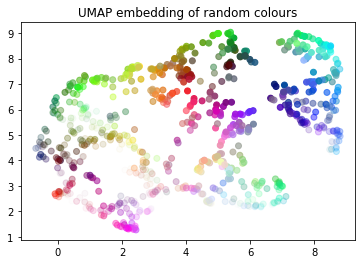

In [6]:
import matplotlib.pyplot as plt
plt.scatter(u[:,0], u[:,1], c=data)
plt.title('UMAP embedding of random colours');